# Lending Tree Loan Status: SMOTE
## Classification - Linear HPO GPU

## Set Up Environment, Read Data, Split Train/Test Sets

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/RAPIDS/

/content/drive/MyDrive/RAPIDS


In [ ]:
# Clone RAPIDS-Colab install files and see if GPU is compatible
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [806 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [982 kB]
Get:12 http://archive.ubuntu.com/ubuntu bi

In [ ]:
# Install CondaColab and restart the kernel 
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:23
🔁 Restarting kernel...


In [ ]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

In [ ]:
# Install/import dependencies
!pip install optuna
!pip install dask_optuna
import os
import warnings
import random
import numpy as np
import cupy 
from cupy import asnumpy
import dask
from dask.distributed import Client, wait
from dask.diagnostics import ProgressBar
from dask.utils import parse_bytes
from dask_cuda import LocalCUDACluster
import dask_cudf
import dask_optuna
import urllib.request
from contextlib import contextmanager
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import cudf
import cuml
from cuml.model_selection import train_test_split
from cuml.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
import joblib
from joblib import parallel_backend
import pickle
import pandas as pd
import sklearn
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
my_dpi=96
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 81 kB 11.1 MB/s 
     |████████████████████████████████| 1.6 MB 91.8 MB/s 
     |████████████████████████████████| 209 kB 72.0 MB/s 
     |████████████████████████████████| 150 kB 73.6 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 146 kB 95.2 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 112 kB 64.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ae29260b7abe6901da8628ad6170ba12fdc4aad2332b35435e252277b132a5c2
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [ ]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', dashboard_address='8081') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

<Client: 'tcp://172.28.0.2:44377' processes=1 threads=1, memory=25.46 GiB>

In [ ]:
# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

In [ ]:
# Set seed 
seed_value = 42
os.environ['Linear_GPU'] = str(seed_value)
random.seed(seed_value)
cupy.random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [ ]:
# Read data
trainDF = cudf.read_csv('trainDF_SMOTE.csv', low_memory=False)
print('Train set: Number of rows and columns:', trainDF.shape)

testDF = cudf.read_csv('testDF_SMOTE.csv', low_memory=False)
print('Test set: Number of rows and columns:', testDF.shape)

Train set: Number of rows and columns: (3022132, 51)
Test set: Number of rows and columns: (432473, 51)


In [ ]:
# Set up features and target
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

## Ridge

### Weighted F1 

#### 100 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_lasso_optuna_SMOTE_1000_weightedF1_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0, solver='eig', 
                   fit_intercept=True, normalize=False, verbose=0, handle=None):
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Weighted F1 score of the fitted model
    """

    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')


    model = Ridge(alpha=alpha, solver=solver, 
                  fit_intercept=fit_intercept, normalize=normalize, 
                  verbose=verbose, handle=handle) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = f1_score(y_test.to_numpy(), cupy.asnumpy(y_pred), average='weighted') 

    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted F1:', score)
    print('######################################################')

    return score

In [ ]:
# With fit_intercept=False, normalize=True
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 8.379925279999952
- Trial weighted F1: 0.9430253281951559
######################################################
Score with default parameters :  0.9430253281951559


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'Ridge_Optuna_SMOTE_1000_GPU_weightedF1.pkl')
    
    # Search parameters
    alpha = trial.suggest_float('alpha', 0, 10) 
    solver = trial.suggest_categorical('solver', ['eig', 'svd'])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, solver=solver, 
                           fit_intercept=True, 
                           normalize=False, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Ridge_Optuna_SMOTE_1000_GPU_weightedF1.pkl'): 
        study = joblib.load('Ridge_Optuna_SMOTE_1000_GPU_weightedF1.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 weighted', study.best_value)

Start Time           2022-06-13 21:57:47.932108
- Trial time: 0.30301593200010757
- Trial weighted F1: 0.9430253281951559
######################################################
- Trial time: 0.6438553620000675
- Trial weighted F1: 0.9659982567962028
######################################################
- Trial time: 0.6470748930000809
- Trial weighted F1: 0.9660007237650728
######################################################
- Trial time: 0.2950121560002117
- Trial weighted F1: 0.9430253281951559
######################################################
- Trial time: 0.6564026780001768
- Trial weighted F1: 0.9659982567962028
######################################################
- Trial time: 0.43764713900009156
- Trial weighted F1: 0.9430253281951559
######################################################
- Trial time: 0.302364922000379
- Trial weighted F1: 0.9430253281951559
######################################################
- Trial time: 0.6682169560003786
- Trial weighted F1: 0

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'f1_weighted'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('f1_weighted', ascending=True)
trials_df.to_csv('Ridge_Optuna_SMOTE_1000_GPU_weightedF1.csv', index=False)
print(trials_df) 

     iteration  f1_weighted             datetime_start  \
0            0     0.943025 2022-06-13 21:57:47.990217   
586        586     0.943025 2022-06-13 22:06:31.437985   
606        606     0.943025 2022-06-13 22:06:50.982867   
624        624     0.943025 2022-06-13 22:07:08.716921   
107        107     0.943025 2022-06-13 21:59:14.949007   
..         ...          ...                        ...   
467        467     0.966001 2022-06-13 22:04:37.568505   
138        138     0.966001 2022-06-13 21:59:41.251877   
458        458     0.966001 2022-06-13 22:04:28.858596   
998        998     0.966001 2022-06-13 22:13:34.519038   
999        999          NaN 2022-06-13 22:13:35.595780   

             datetime_complete               duration     alpha solver  \
0   2022-06-13 21:57:48.486985 0 days 00:00:00.496768  6.978354    eig   
586 2022-06-13 22:06:32.065139 0 days 00:00:00.627154  4.770809    eig   
606 2022-06-13 22:06:51.620120 0 days 00:00:00.637253  6.029669    eig   
624 202

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Ridge_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Ridge_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Ridge_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'solver'])
py.plot(fig, filename='contour_Ridge_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

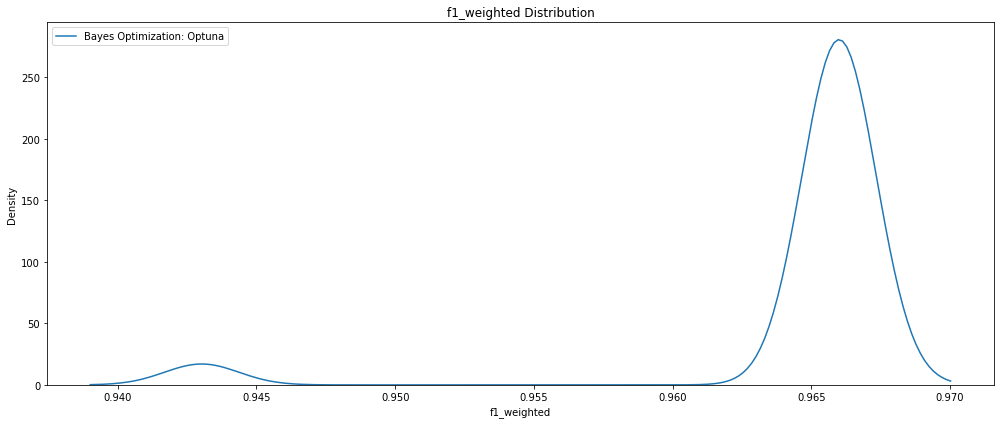

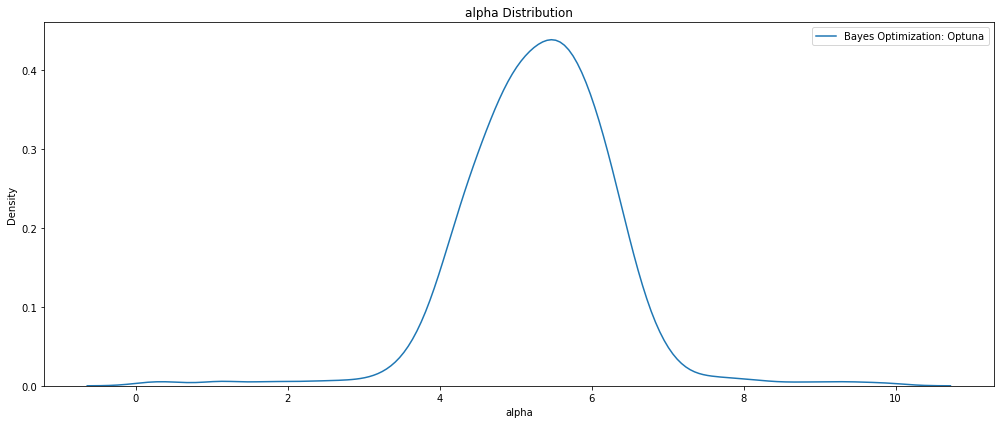

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','solver', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Ridge_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Ridge_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'alpha': 4.5730890277211245, 'solver': 'svd'}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = Ridge(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Ridge_Optuna_SMOTE_trials1000_GPU_weightedF1.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Ridge_Optuna_SMOTE_trials1000_GPU_weightedF1.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Ridge HPO SMOTE 1000 GPU F1 Weighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Ridge HPO SMOTE 1000 GPU F1 Weighted


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    377848
           1       0.88      0.85      0.86     54625

    accuracy                           0.97    432473
   macro avg       0.93      0.92      0.92    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[371474   6374]
 [  8222  46403]]


Accuracy score : 0.966
Precision score : 0.879
Recall score : 0.849
F1 score : 0.864


In [ ]:
# Evaluate on the testing data 
print('The best model from Ridge HPO SMOTE 1000 GPU F1 Weighted trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                                 cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Ridge HPO SMOTE 1000 GPU F1 Weighted trials optimization scores 0.91631 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                     0
f1_weighted                            0.943025
datetime_start       2022-06-13 21:57:47.990217
datetime_complete    2022-06-13 21:57:48.486985
duration                 0 days 00:00:00.496768
alpha                                  6.978354
solver                                      eig
state                                  COMPLETE
Name: 0, dtype: object


### Weighted ROC

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_ridge_optuna_SMOTE_1000_weightedROC_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0, solver='eig', 
                   fit_intercept=True, normalize=False, verbose=0, handle=None):
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: ROC weighted of the fitted model
    """

    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = Ridge(alpha=alpha, solver=solver, 
                  fit_intercept=fit_intercept, 
                  normalize=normalize,
                  verbose=verbose, 
                  handle=handle) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = roc_auc_score(y_test.to_numpy(), cupy.asnumpy(y_pred), 
                          average='weighted')
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted ROC:', score)
    print('######################################################')

    return score

In [ ]:
# With fit_intercept=False, normalize=True
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 0.22949393399994733
- Trial weighted ROC: 0.8957569361491093
######################################################
Score with default parameters :  0.8957569361491093


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'Ridge_Optuna_SMOTE_1000_GPU_ROCweighted.pkl')
    
    # Search parameters
    alpha = trial.suggest_float('alpha', 0, 10) 
    solver = trial.suggest_categorical('solver', ['eig', 'svd'])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, solver=solver, 
                           fit_intercept=True, 
                           normalize=False, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Ridge_Optuna_SMOTE_1000_GPU_ROCweighted.pkl'): 
        study = joblib.load('Ridge_Optuna_SMOTE_1000_GPU_ROCweighted.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted score', study.best_value)

Start Time           2022-06-13 22:13:43.915783
- Trial time: 0.5894729729998289
- Trial weighted ROC: 0.9163054868551745
######################################################
- Trial time: 0.5959683169999153
- Trial weighted ROC: 0.9163054868551745
######################################################
- Trial time: 0.6066991249999774
- Trial weighted ROC: 0.9163054868551745
######################################################
- Trial time: 0.5997007460000532
- Trial weighted ROC: 0.9163054868551745
######################################################
- Trial time: 0.2398742850000417
- Trial weighted ROC: 0.8957569361491093
######################################################
- Trial time: 0.5864800069998637
- Trial weighted ROC: 0.9162976568205335
######################################################
- Trial time: 0.23043948300028205
- Trial weighted ROC: 0.8957569361491093
######################################################
- Trial time: 0.604129660000126
- Trial weighted

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'roc_weighted'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('roc_weighted', ascending=True)
trials_df.to_csv('Ridge_Optuna_SMOTE_1000_GPU_ROCweighted.csv', index=False)
print(trials_df) 

     iteration  roc_weighted             datetime_start  \
724        724      0.895757 2022-06-13 22:23:55.934124   
411        411      0.895757 2022-06-13 22:19:14.395517   
897        897      0.895757 2022-06-13 22:26:42.954443   
627        627      0.895757 2022-06-13 22:22:25.430862   
760        760      0.895757 2022-06-13 22:24:30.062884   
..         ...           ...                        ...   
478        478      0.916307 2022-06-13 22:20:11.941226   
479        479      0.916307 2022-06-13 22:20:12.823524   
480        480      0.916307 2022-06-13 22:20:13.716063   
458        458      0.916307 2022-06-13 22:19:54.681861   
999        999      0.916307 2022-06-13 22:28:24.902424   

             datetime_complete               duration     alpha solver  \
724 2022-06-13 22:23:56.543937 0 days 00:00:00.609813  6.079137    eig   
411 2022-06-13 22:19:14.911987 0 days 00:00:00.516470  4.330558    eig   
897 2022-06-13 22:26:43.590248 0 days 00:00:00.635805  4.847407    ei

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Ridge_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Ridge_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Ridge_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'solver'])
py.plot(fig, filename='contour_Ridge_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

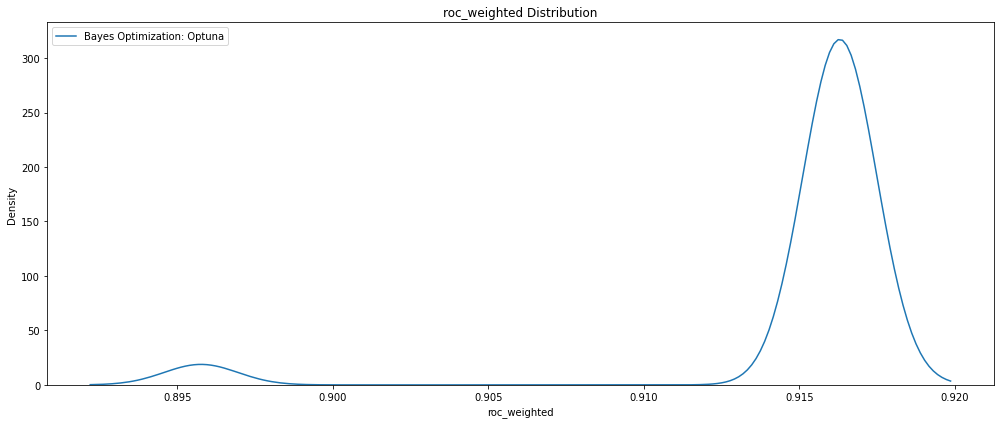

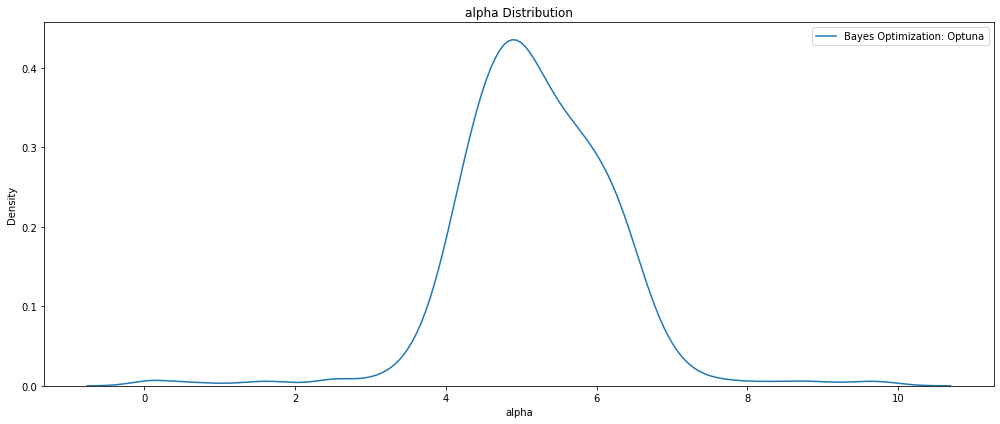

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','solver', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Ridge_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Ridge_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'alpha': 6.224714256573553, 'solver': 'svd'}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = Ridge(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Ridge_Optuna_SMOTE_trials1000_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Ridge_Optuna_SMOTE_trials1000_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Ridge HPO 1000 GPU ROC Weighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Ridge HPO 1000 GPU ROC Weighted


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    377848
           1       0.88      0.85      0.86     54625

    accuracy                           0.97    432473
   macro avg       0.93      0.92      0.92    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[371474   6374]
 [  8222  46403]]


Accuracy score : 0.966
Precision score : 0.879
Recall score : 0.849
F1 score : 0.864


In [ ]:
# Evaluate on the testing data 
print('The best model from Ridge HPO 1000 GPU ROC Weighted trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                            cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Ridge HPO 1000 GPU ROC Weighted trials optimization scores 0.91631 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   724
roc_weighted                           0.895757
datetime_start       2022-06-13 22:23:55.934124
datetime_complete    2022-06-13 22:23:56.543937
duration                 0 days 00:00:00.609813
alpha                                  6.079137
solver                                      eig
state                                  COMPLETE
Name: 724, dtype: object


### Recall

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_ridge_optuna_SMOTE_1000_Recall_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0, solver='eig', 
                   fit_intercept=True, normalize=False, verbose=0, handle=None):
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Recall score of the fitted model
    """

    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')


    model = Ridge(alpha=alpha, solver=solver, 
                  fit_intercept=fit_intercept, 
                  normalize=normalize, 
                  verbose=verbose, handle=handle) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = recall_score(y_test.to_numpy(), cupy.asnumpy(y_pred))
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial recall score:', score)
    print('######################################################')

    return score

In [ ]:
# With fit_intercept=False, normalize=True
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 0.3152822259999084
- Trial recall score: 0.8345629290617849
######################################################
Score with default parameters :  0.8345629290617849


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'Ridge_Optuna_SMOTE_1000_GPU_Recall.pkl')
    
    # Search parameters
    alpha = trial.suggest_float('alpha', 0, 10) 
    solver = trial.suggest_categorical('solver', ['eig', 'svd'])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, solver=solver, 
                           fit_intercept=True, 
                           normalize=False, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Ridge_Optuna_SMOTE_1000_GPU_Recall.pkl'): 
        study = joblib.load('Ridge_Optuna_SMOTE_1000_GPU_Recall.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall score', study.best_value)

Start Time           2022-06-13 22:28:32.959355
- Trial time: 0.6635869819997424
- Trial recall score: 0.8494828375286041
######################################################
- Trial time: 0.6373725540001942
- Trial recall score: 0.8494828375286041
######################################################
- Trial time: 0.3075180079999882
- Trial recall score: 0.8345629290617849
######################################################
- Trial time: 0.6556820490000064
- Trial recall score: 0.8494828375286041
######################################################
- Trial time: 0.6419523310000841
- Trial recall score: 0.8494828375286041
######################################################
- Trial time: 0.6589448570002787
- Trial recall score: 0.8494828375286041
######################################################
- Trial time: 0.64420326499976
- Trial recall score: 0.8494828375286041
######################################################
- Trial time: 0.3071772159996726
- Trial recall sco

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'recall'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('recall', ascending=True)
trials_df.to_csv('Ridge_Optuna_SMOTE_1000_GPU_Recall.csv', index=False)
print(trials_df) 

     iteration    recall             datetime_start  \
526        526  0.834563 2022-06-13 22:36:19.592615   
89          89  0.834563 2022-06-13 22:29:45.240433   
798        798  0.834563 2022-06-13 22:40:50.780548   
585        585  0.834563 2022-06-13 22:37:17.008072   
701        701  0.834563 2022-06-13 22:39:11.916540   
..         ...       ...                        ...   
357        357  0.849483 2022-06-13 22:33:42.152543   
358        358  0.849483 2022-06-13 22:33:43.085538   
359        359  0.849483 2022-06-13 22:33:44.019978   
346        346  0.849483 2022-06-13 22:33:32.549914   
999        999  0.849483 2022-06-13 22:44:23.291879   

             datetime_complete               duration     alpha solver  \
526 2022-06-13 22:36:20.196928 0 days 00:00:00.604313  0.974526    eig   
89  2022-06-13 22:29:45.699982 0 days 00:00:00.459549  3.583867    eig   
798 2022-06-13 22:40:51.471986 0 days 00:00:00.691438  1.446538    eig   
585 2022-06-13 22:37:17.660418 0 days 00:00

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Ridge_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Ridge_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Ridge_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'solver'])
py.plot(fig, filename='contour_Ridge_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

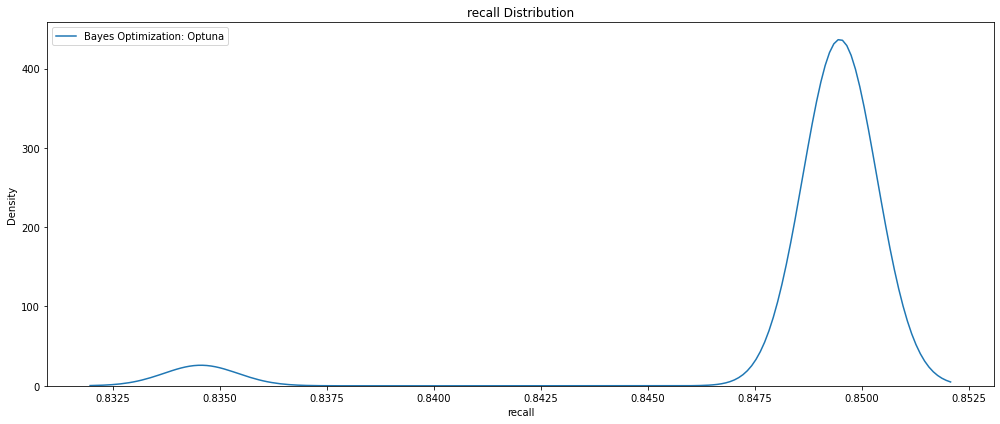

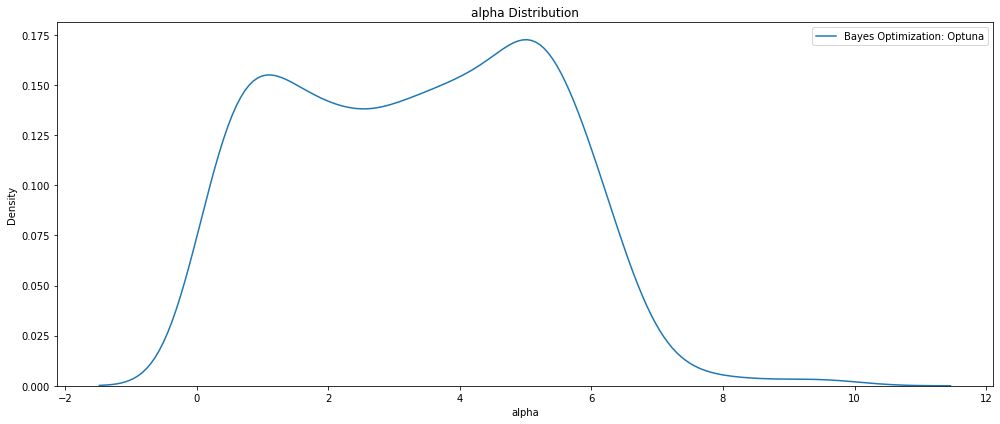

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','solver', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Ridge_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Ridge_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'alpha': 0.8907411415967548, 'solver': 'svd'}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = Ridge(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Ridge_Optuna_SMOTE_trials1000_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Ridge_Optuna_SMOTE_trials1000_GPU_Recall.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Ridge HPO 1000 GPU Recall')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Ridge HPO 1000 GPU Recall


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    377848
           1       0.88      0.85      0.86     54625

    accuracy                           0.97    432473
   macro avg       0.93      0.92      0.92    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[371473   6375]
 [  8222  46403]]


Accuracy score : 0.966
Precision score : 0.879
Recall score : 0.849
F1 score : 0.864


In [ ]:
# Evaluate on the testing data 
print('The best model from Ridge HPO 1000 GPU Recall trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                      cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Ridge HPO 1000 GPU Recall trials optimization scores 0.91631 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   526
recall                                 0.834563
datetime_start       2022-06-13 22:36:19.592615
datetime_complete    2022-06-13 22:36:20.196928
duration                 0 days 00:00:00.604313
alpha                                  0.974526
solver                                      eig
state                                  COMPLETE
Name: 526, dtype: object


### Precision

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_ridge_optuna_SMOTE_1000_Precision_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0, solver='eig', 
                   fit_intercept=True, normalize=False, verbose=0, handle=None):
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Precision score of the fitted model
    """

    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')


    model = Ridge(alpha=alpha, solver=solver, 
                  fit_intercept=fit_intercept, 
                  normalize=normalize, 
                  verbose=verbose, handle=handle) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = precision_score(y_test.to_numpy(), cupy.asnumpy(y_pred))
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial Precision score:', score)
    print('######################################################')

    return score

In [ ]:
# With fit_intercept=False, normalize=True
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 0.29188542799965944
- Trial Precision score: 0.7370258996992919
######################################################
Score with default parameters :  0.7370258996992919


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'Ridge_Optuna_SMOTE_1000_GPU_Precision.pkl')
    
    # Search parameters
    alpha = trial.suggest_float('alpha', 0, 10) 
    solver = trial.suggest_categorical('solver', ['eig', 'svd'])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, solver=solver, 
                           fit_intercept=True, 
                           normalize=False, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Ridge_Optuna_SMOTE_1000_GPU_Precision.pkl'): 
        study = joblib.load('Ridge_Optuna_SMOTE_1000_GPU_Precision.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision score', study.best_value)

Start Time           2022-06-13 22:44:31.232298
- Trial time: 0.29832914199960214
- Trial Precision score: 0.7370258996992919
######################################################
- Trial time: 0.66316175799966
- Trial Precision score: 0.8792110349009057
######################################################
- Trial time: 0.297725458000059
- Trial Precision score: 0.7370258996992919
######################################################
- Trial time: 0.3020022919999974
- Trial Precision score: 0.7370258996992919
######################################################
- Trial time: 0.2957009739993737
- Trial Precision score: 0.7370258996992919
######################################################
- Trial time: 0.29328372300005867
- Trial Precision score: 0.7370258996992919
######################################################
- Trial time: 0.6493463870001506
- Trial Precision score: 0.8792276938818046
######################################################
- Trial time: 0.6543718530001

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'precision'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_solver':'solver'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('precision', ascending=True)
trials_df.to_csv('Ridge_Optuna_SMOTE_1000_GPU_Precision.csv', index=False)
print(trials_df) 

     iteration  precision             datetime_start  \
0            0   0.737026 2022-06-13 22:44:31.234479   
374        374   0.737026 2022-06-13 22:49:55.130512   
917        917   0.737026 2022-06-13 22:58:52.601548   
765        765   0.737026 2022-06-13 22:56:13.926694   
129        129   0.737026 2022-06-13 22:46:16.618144   
..         ...        ...                        ...   
392        392   0.879228 2022-06-13 22:50:11.578096   
394        394   0.879228 2022-06-13 22:50:13.099730   
396        396   0.879228 2022-06-13 22:50:14.971834   
383        383   0.879228 2022-06-13 22:50:03.170282   
999        999   0.879228 2022-06-13 23:00:21.111139   

             datetime_complete               duration     alpha solver  \
0   2022-06-13 22:44:31.694184 0 days 00:00:00.459705  1.930289    eig   
374 2022-06-13 22:49:55.723486 0 days 00:00:00.592974  5.696077    eig   
917 2022-06-13 22:58:53.315081 0 days 00:00:00.713533  6.241069    eig   
765 2022-06-13 22:56:14.593717 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Ridge_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Ridge_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Ridge_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'solver'])
py.plot(fig, filename='contour_Ridge_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

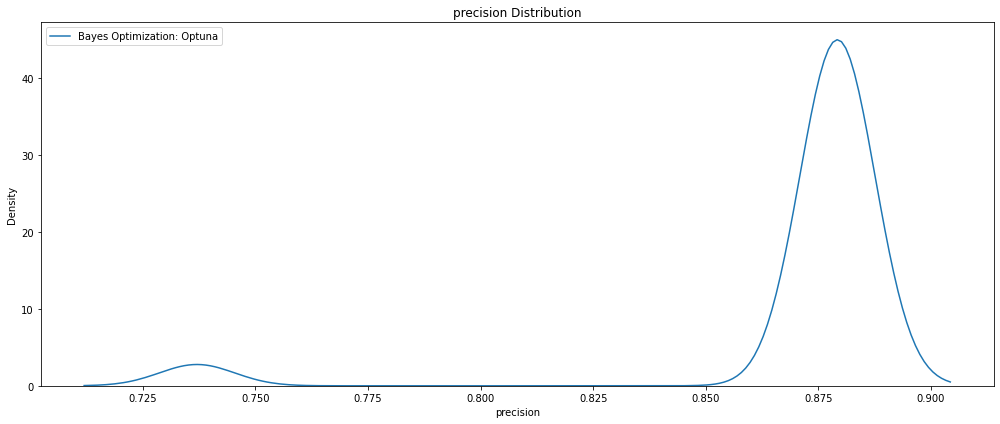

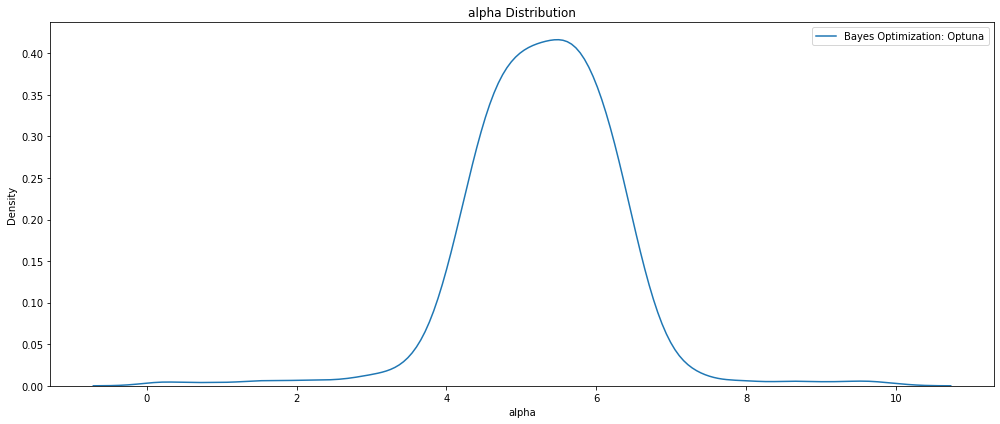

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration', 'solver', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Ridge_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Ridge_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'alpha': 5.0833964869678985, 'solver': 'svd'}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = Ridge(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Ridge_Optuna_SMOTE_trials1000_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Ridge_Optuna_SMOTE_trials1000_GPU_Precision.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Ridge HPO 1000 GPU Precision')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Ridge HPO 1000 GPU Precision


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    377848
           1       0.88      0.85      0.86     54625

    accuracy                           0.97    432473
   macro avg       0.93      0.92      0.92    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[371474   6374]
 [  8222  46403]]


Accuracy score : 0.966
Precision score : 0.879
Recall score : 0.849
F1 score : 0.864


In [ ]:
# Evaluate on the testing data 
print('The best model from Ridge HPO 1000 GPU Precision trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                         cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Ridge HPO 1000 GPU Precision trials optimization scores 0.91631 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                     0
precision                              0.737026
datetime_start       2022-06-13 22:44:31.234479
datetime_complete    2022-06-13 22:44:31.694184
duration                 0 days 00:00:00.459705
alpha                                  1.930289
solver                                      eig
state                                  COMPLETE
Name: 0, dtype: object


## Lasso

### F1 Weighted

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_lasso_optuna_SMOTE_1000_weightedF1_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0, 
                   max_iter=1e6, tol=1e-3, selection='cyclic', 
                   fit_intercept=True, normalize=False, verbose=0,
                   handle=None): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Weighted F1 of the fitted model
    """
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = Lasso(alpha=alpha, max_iter=max_iter, tol=tol, 
                  selection=selection, fit_intercept=fit_intercept, 
                  normalize=normalize, verbose=verbose, handle=handle) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = f1_score(y_test.to_numpy(), cupy.asnumpy(y_pred), average='weighted') 

    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted F1:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 1.0975655840002219
- Trial weighted F1: 0.9783279289389413
######################################################
Score with default parameters :  0.9783279289389413


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Lasso_Optuna_SMOTE_1000_GPU.pkl')
    
    # Search parameters
    alpha = trial.suggest_float('alpha', 1e-3, 2.0) 
    max_iter = trial.suggest_int('max_iter', 1e5, 1e7) 
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, max_iter=max_iter, 
                           tol=tol, selection=selection,
                           fit_intercept=True, 
                           normalize=False, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Lasso_Optuna_SMOTE_1000_GPU.pkl'): 
        study = joblib.load('Lasso_Optuna_SMOTE_1000_GPU.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 score', study.best_value)

Start Time           2022-06-13 23:00:31.114909
- Trial time: 0.367913853000573
- Trial weighted F1: 0.9798316695914467
######################################################
- Trial time: 0.373112434000177
- Trial weighted F1: 0.9796410536447229
######################################################
- Trial time: 0.340167952000229
- Trial weighted F1: 0.9806755146046284
######################################################
- Trial time: 0.3806298549998246
- Trial weighted F1: 0.9796135416424823
######################################################
- Trial time: 0.32447453799977666
- Trial weighted F1: 0.9687736572043821
######################################################
- Trial time: 0.421414704000199
- Trial weighted F1: 0.9791624370710422
######################################################
- Trial time: 0.3326668409999911
- Trial weighted F1: 0.980509845599694
######################################################
- Trial time: 0.31723139100085973
- Trial weighted F1: 0.969

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'f1_weighted'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_fit_intercept':'fit_intercept'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_normalize':'normalize'}, inplace=True)
trials_df.rename(columns={'params_selection':'selection'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)

# Write processed data to csv    
trials_df = trials_df.sort_values('f1_weighted', ascending=False)
trials_df.to_csv('Lasso_Optuna_SMOTE_1000_GPU_F1weighted.csv', index=False)
print(trials_df)

     iteration  f1_weighted             datetime_start  \
499        499     0.980779 2022-06-13 23:05:46.214263   
427        427     0.980779 2022-06-13 23:04:54.551315   
458        458     0.980779 2022-06-13 23:05:16.553962   
457        457     0.980779 2022-06-13 23:05:15.869673   
456        456     0.980779 2022-06-13 23:05:15.193710   
..         ...          ...                        ...   
34          34     0.960025 2022-06-13 23:00:50.316256   
111        111     0.959974 2022-06-13 23:01:34.549986   
985        985     0.956546 2022-06-13 23:12:19.400867   
582        582     0.951908 2022-06-13 23:06:46.872128   
999        999          NaN 2022-06-13 23:12:32.037329   

             datetime_complete               duration     alpha   max_iter  \
499 2022-06-13 23:05:46.901334 0 days 00:00:00.687071  1.918376  9166302.0   
427 2022-06-13 23:04:55.226907 0 days 00:00:00.675592  1.998017  9390829.0   
458 2022-06-13 23:05:17.248719 0 days 00:00:00.694757  1.923302  9244

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Lasso_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Lasso_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Lasso_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'max_iter', 'tol'])
py.plot(fig, filename='contour_Lasso_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

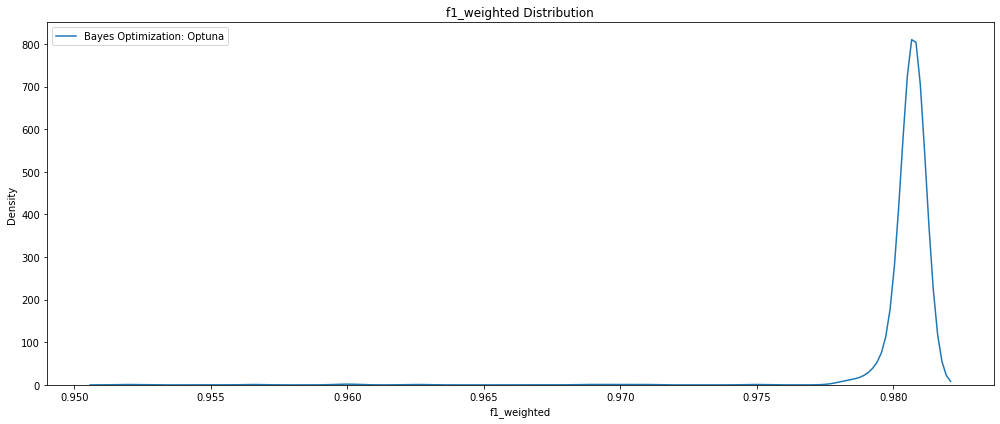

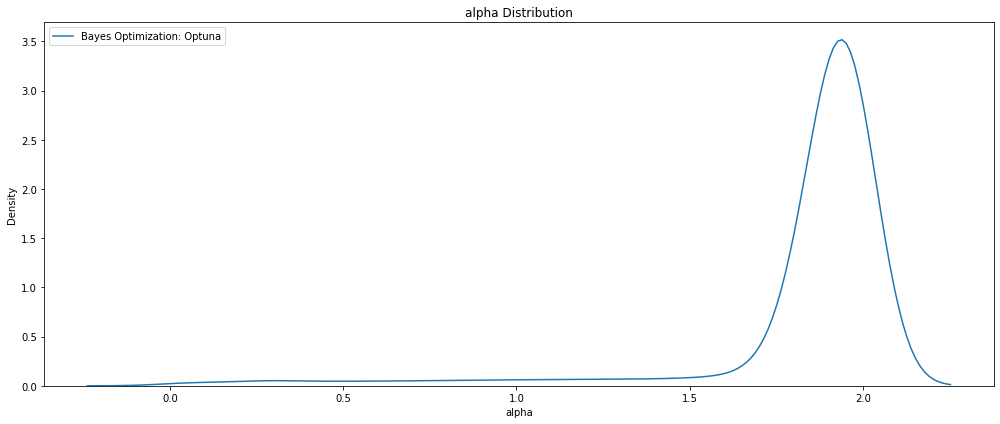

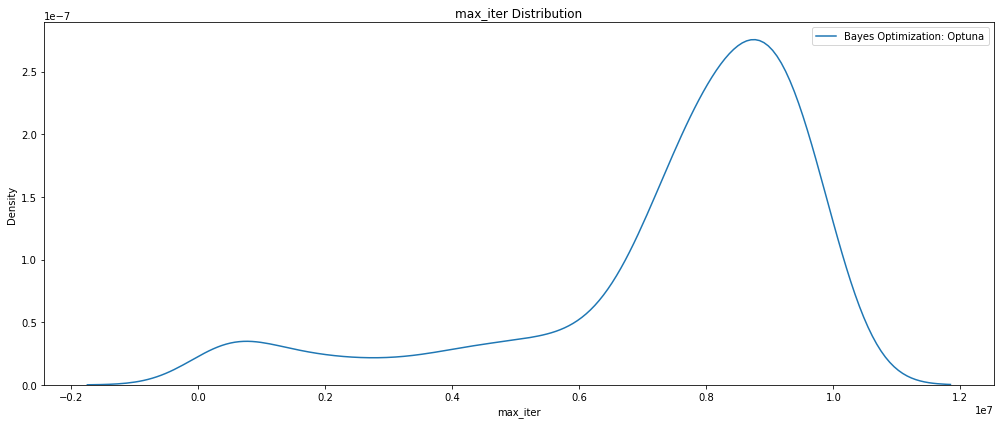

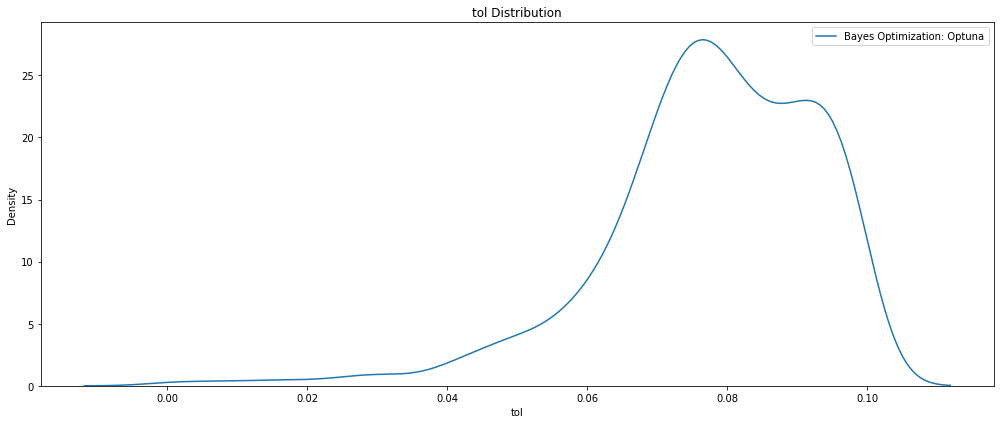

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','fit_intercept', 'normalize', 'selection',
                   'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

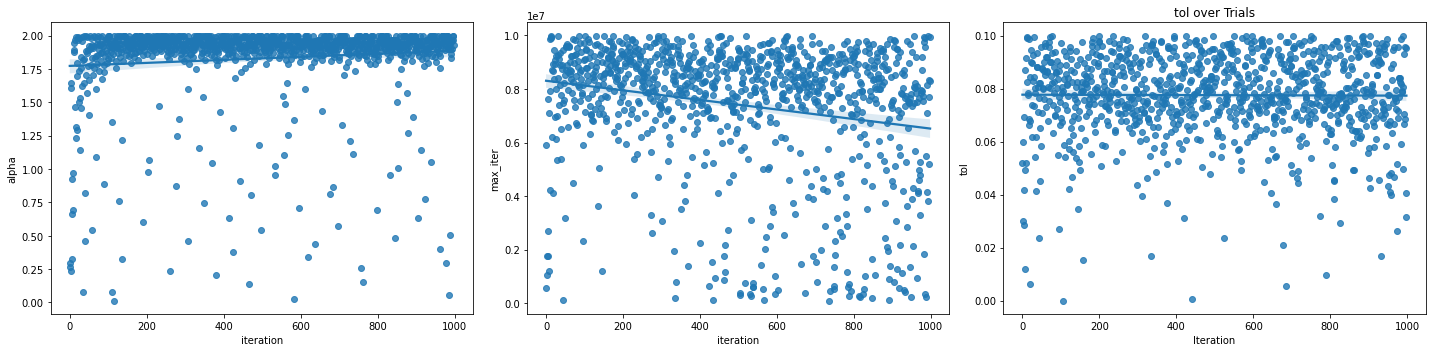

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['alpha', 'max_iter', 'tol']): 
                        # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo), 
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Lasso_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Lasso_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'alpha': 1.9466217131397778,
 'max_iter': 9902809,
 'selection': 'random',
 'tol': 0.09921790011864844}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = Lasso(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Lasso_Optuna_SMOTE_trials1000_GPU_F1weighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Lasso_Optuna_SMOTE_trials1000_GPU_F1weighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Lasso HPO SMOTE 1000 F1weighted GPU trials')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Lasso HPO SMOTE 1000 F1weighted GPU trials


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    377848
           1       1.00      0.85      0.92     54625

    accuracy                           0.98    432473
   macro avg       0.99      0.93      0.96    432473
weighted avg       0.98      0.98      0.98    432473



Confusion matrix:
[[377843      5]
 [  8031  46594]]


Accuracy score : 0.981
Precision score : 1.000
Recall score : 0.853
F1 score : 0.921


In [ ]:
# Evaluate on the testing data 
print('The best model from Lasso HPO SMOTE 1000 F1weighted GPU Precision trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                                          cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Lasso HPO SMOTE 1000 F1weighted GPU Precision trials optimization scores 0.92648 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   499
f1_weighted                            0.980779
datetime_start       2022-06-13 23:05:46.214263
datetime_complete    2022-06-13 23:05:46.901334
duration                 0 days 00:00:00.687071
alpha                                  1.918376
max_iter                              9166302.0
selection                                random
tol                                    0.091548
state                                  COMPLETE
Name: 499, dtype: object


### ROC Weighted

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_lasso_optuna_SMOTE_1000_weightedROC_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0, 
                   max_iter=1e6, tol=1e-3, selection='cyclic', 
                   fit_intercept=True, normalize=False, verbose=0,
                   handle=None): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Weighted ROC of the fitted model
    """

    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = Lasso(alpha=alpha, max_iter=max_iter, tol=tol, 
                  selection=selection, fit_intercept=fit_intercept, 
                  normalize=normalize, verbose=verbose, handle=handle) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = roc_auc_score(y_test.to_numpy(), cupy.asnumpy(y_pred), 
                          average='weighted') 

    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted ROC:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 1.0387881679998827
- Trial weighted ROC: 0.9174449009728561
######################################################
Score with default parameters :  0.9174449009728561


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Lasso_Optuna_SMOTE_1000_GPU_ROCweighted.pkl')
    
    # Search parameters
    alpha = trial.suggest_float('alpha', 1e-3, 2.0) 
    max_iter = trial.suggest_int('max_iter', 1e5, 1e7) 
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, max_iter=max_iter, 
                           tol=tol, selection=selection,
                           fit_intercept=True, 
                           normalize=False, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Lasso_Optuna_SMOTE_1000_GPU_ROCweighted.pkl'): 
        study = joblib.load('Lasso_Optuna_SMOTE_1000_GPU_ROCweighted.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted score', study.best_value)

Start Time           2022-06-13 23:14:23.593313
- Trial time: 0.4231121759994494
- Trial weighted ROC: 0.9186348323229706
######################################################
- Trial time: 0.3797618210001019
- Trial weighted ROC: 0.9219574867852132
######################################################
- Trial time: 0.3429403350000939
- Trial weighted ROC: 0.9244367929094004
######################################################
- Trial time: 0.2788483679996716
- Trial weighted ROC: 0.9254343147053622
######################################################
- Trial time: 0.5023823179999454
- Trial weighted ROC: 0.9202063444252061
######################################################
- Trial time: 0.4374989110001479
- Trial weighted ROC: 0.9223142541499744
######################################################
- Trial time: 0.3203123510002115
- Trial weighted ROC: 0.922058173284069
######################################################
- Trial time: 0.4045605359997353
- Trial weighted 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'roc_weighted'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_fit_intercept':'fit_intercept'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_normalize':'normalize'}, inplace=True)
trials_df.rename(columns={'params_selection':'selection'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('roc_weighted', ascending=False)
trials_df.to_csv('Lasso_Optuna_SMOTE_1000_GPU_ROCweighted.csv', index=False)
print(trials_df) 

     iteration  roc_weighted             datetime_start  \
924        924      0.928894 2022-06-13 23:24:41.282317   
799        799      0.928894 2022-06-13 23:22:58.618350   
998        998      0.928890 2022-06-13 23:25:45.522488   
804        804      0.928890 2022-06-13 23:23:02.733194   
775        775      0.928882 2022-06-13 23:22:39.725893   
..         ...           ...                        ...   
241        241      0.914841 2022-06-13 23:16:34.272492   
50          50      0.910837 2022-06-13 23:14:50.482973   
567        567      0.910007 2022-06-13 23:20:03.198282   
666        666      0.909023 2022-06-13 23:21:15.765361   
999        999           NaN 2022-06-13 23:25:46.361398   

             datetime_complete               duration     alpha   max_iter  \
924 2022-06-13 23:24:42.104233 0 days 00:00:00.821916  0.216810   932207.0   
799 2022-06-13 23:22:59.377413 0 days 00:00:00.759063  0.217254  1870112.0   
998 2022-06-13 23:25:46.360633 0 days 00:00:00.838145  0.

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Lasso_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Lasso_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Lasso_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'max_iter', 'tol'])
py.plot(fig, filename='contour_Lasso_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

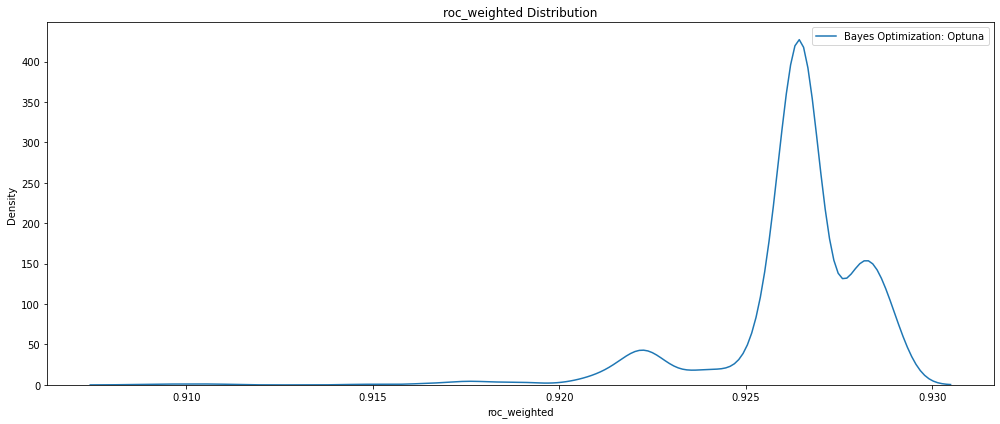

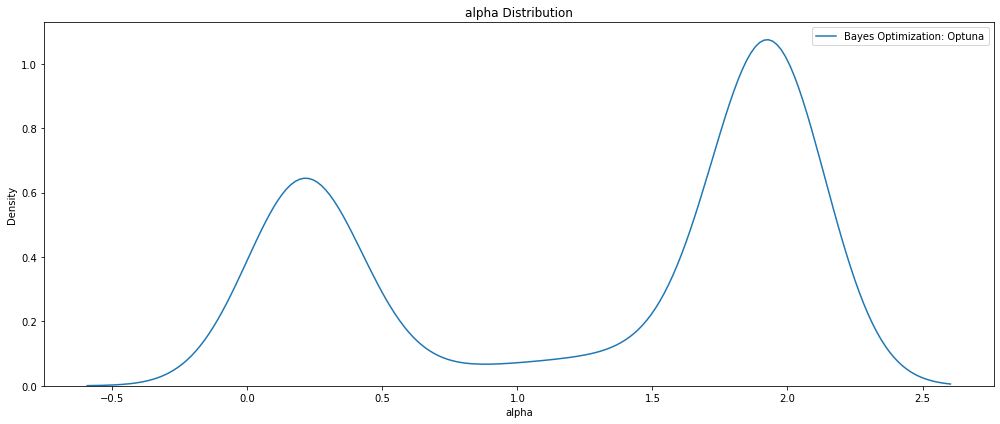

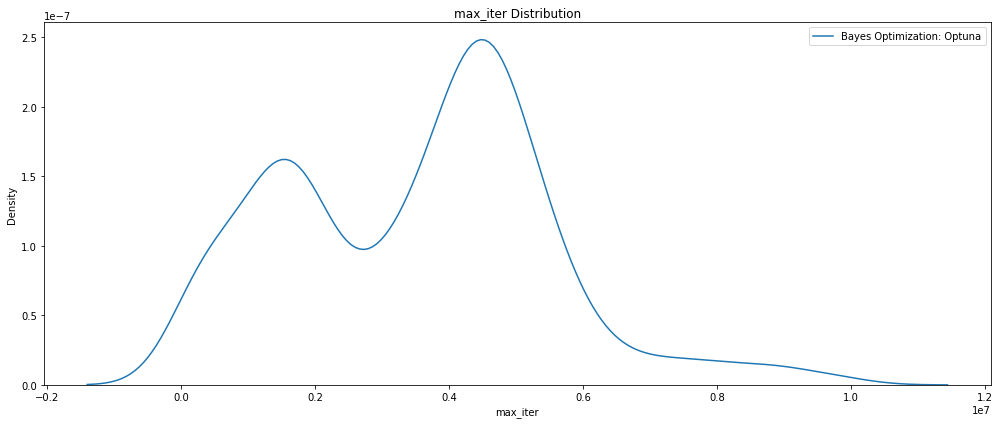

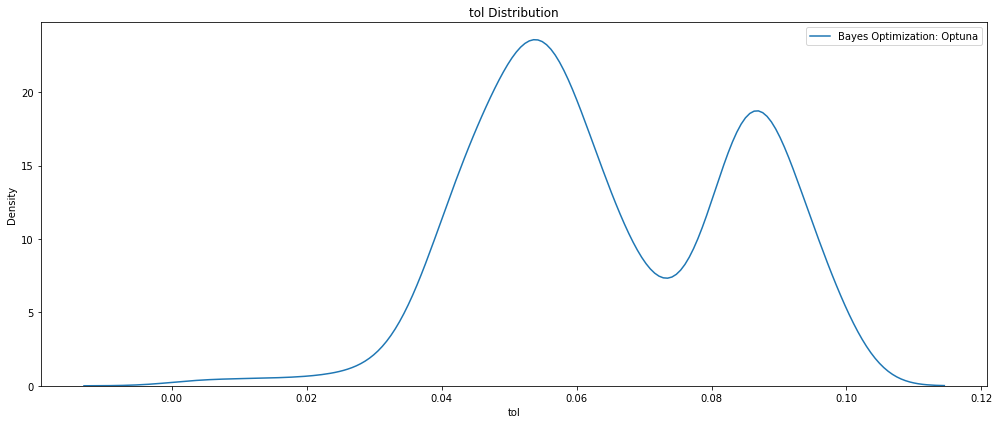

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','fit_intercept', 'normalize', 'selection',
                   'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

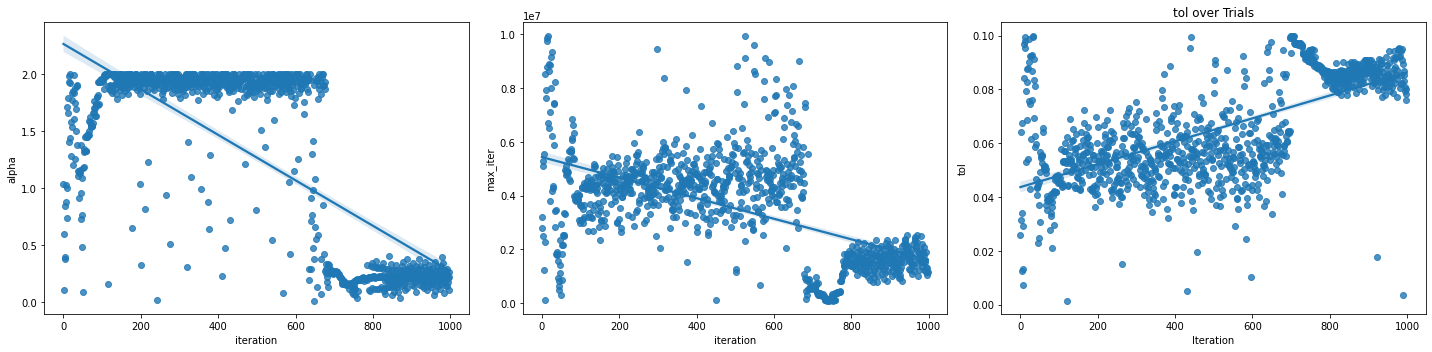

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['alpha', 'max_iter', 'tol']): 
                        # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Lasso_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Lasso_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'alpha': 0.21725355843200453,
 'max_iter': 1870112,
 'selection': 'cyclic',
 'tol': 0.08518671067658272}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = Lasso(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Lasso_Optuna_SMOTE_trials1000_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Lasso_Optuna_SMOTE_trials1000_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Lasso HPO SMOTE 1000 ROCweighted GPU trials')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Lasso HPO SMOTE 1000 ROCweighted GPU trials


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    377848
           1       0.94      0.87      0.90     54625

    accuracy                           0.98    432473
   macro avg       0.96      0.93      0.94    432473
weighted avg       0.98      0.98      0.98    432473



Confusion matrix:
[[374588   3260]
 [  7297  47328]]


Accuracy score : 0.976
Precision score : 0.936
Recall score : 0.866
F1 score : 0.900


In [ ]:
# Evaluate on the testing data 
print('The best model from Lasso HPO SMOTE 1000 ROC weighted GPU Precision trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                                            cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Lasso HPO SMOTE 1000 ROC weighted GPU Precision trials optimization scores 0.92889 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   924
roc_weighted                           0.928894
datetime_start       2022-06-13 23:24:41.282317
datetime_complete    2022-06-13 23:24:42.104233
duration                 0 days 00:00:00.821916
alpha                                   0.21681
max_iter                               932207.0
selection                                cyclic
tol                                    0.087283
state                                  COMPLETE
Name: 924, dtype: object


### Recall

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_lasso_optuna_SMOTE_1000_Recall_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0, 
                   max_iter=1e6, tol=1e-3, selection='cyclic', 
                   fit_intercept=True, normalize=False, verbose=0,
                   handle=None): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Recall of the fitted model
    """
    
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32') 
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = Lasso(alpha=alpha, max_iter=max_iter, tol=tol, 
                  selection=selection, fit_intercept=fit_intercept, 
                  normalize=normalize, verbose=verbose, handle=handle) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = recall_score(y_test.to_numpy(), cupy.asnumpy(y_pred)) 

    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial Recall score:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 1.1024333389996173
- Trial Recall score: 0.8348924485125858
######################################################
Score with default parameters :  0.8348924485125858


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Lasso_Optuna_SMOTE_1000_GPU_Recall.pkl')
    
    # Search parameters
    alpha = trial.suggest_float('alpha', 1e-3, 2.0) 
    max_iter = trial.suggest_int('max_iter', 1e5, 1e7) 
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, max_iter=max_iter, 
                           tol=tol, selection=selection,
                           fit_intercept=True, 
                           normalize=False, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Lasso_Optuna_SMOTE_1000_GPU_Recall.pkl'): 
        study = joblib.load('Lasso_Optuna_SMOTE_1000_GPU_Recall.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall score', study.best_value)

Start Time           2022-06-13 23:28:23.621517
- Trial time: 0.4897029150006347
- Trial Recall score: 0.8416842105263158
######################################################
- Trial time: 0.34355249800046295
- Trial Recall score: 0.8508741418764302
######################################################
- Trial time: 0.41519239300032496
- Trial Recall score: 0.844045766590389
######################################################
- Trial time: 0.9937739110000621
- Trial Recall score: 0.8350572082379862
######################################################
- Trial time: 0.47809490200052096
- Trial Recall score: 0.8446315789473684
######################################################
- Trial time: 0.38200840199988306
- Trial Recall score: 0.8513684210526316
######################################################
- Trial time: 0.5733698180001738
- Trial Recall score: 0.842050343249428
######################################################
- Trial time: 0.4175226269999257
- Trial Recall

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'recall'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_fit_intercept':'fit_intercept'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_normalize':'normalize'}, inplace=True)
trials_df.rename(columns={'params_selection':'selection'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('recall', ascending=False)
trials_df.to_csv('Lasso_Optuna_SMOTE_1000_GPU_Recall.csv', index=False)
print(trials_df) 

     iteration    recall             datetime_start  \
929        929  0.873739 2022-06-13 23:39:47.273320   
895        895  0.873721 2022-06-13 23:39:16.350709   
742        742  0.873703 2022-06-13 23:37:03.104675   
746        746  0.873684 2022-06-13 23:37:06.426948   
814        814  0.873684 2022-06-13 23:38:05.004875   
..         ...       ...                        ...   
152        152  0.835277 2022-06-13 23:29:54.773475   
593        593  0.835185 2022-06-13 23:35:01.648104   
84          84  0.835130 2022-06-13 23:29:13.628088   
3            3  0.835057 2022-06-13 23:28:25.382758   
9            9  0.834728 2022-06-13 23:28:29.774625   

             datetime_complete               duration     alpha  max_iter  \
929 2022-06-13 23:39:48.132259 0 days 00:00:00.858939  0.218231    370243   
895 2022-06-13 23:39:17.200017 0 days 00:00:00.849308  0.218291   1401550   
742 2022-06-13 23:37:03.895294 0 days 00:00:00.790619  0.218421    857580   
746 2022-06-13 23:37:07.232403 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Lasso_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Lasso_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Lasso_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'max_iter', 'tol'])
py.plot(fig, filename='contour_Lasso_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

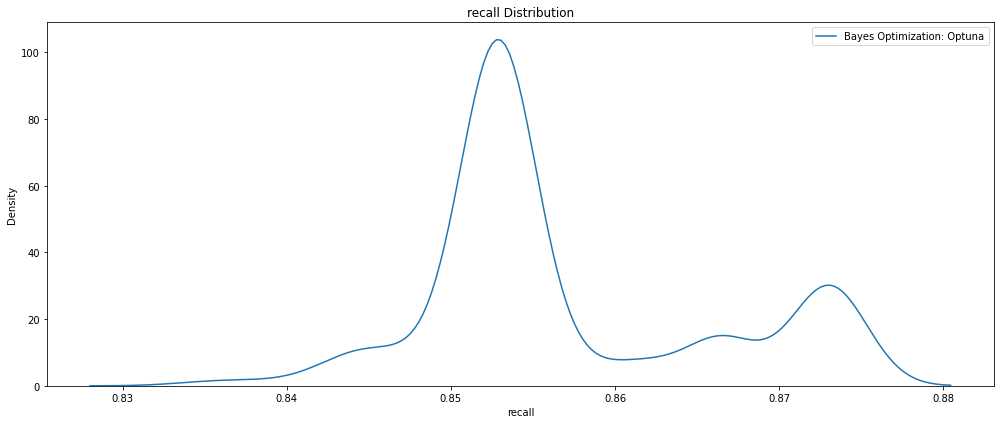

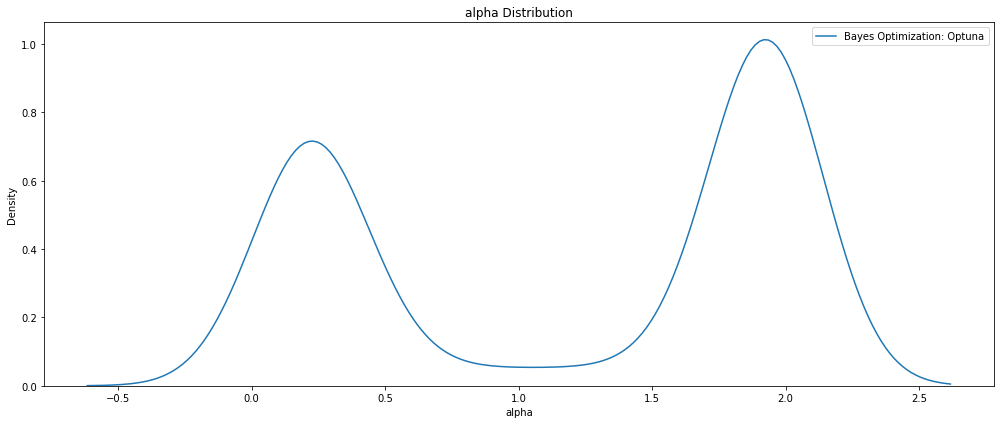

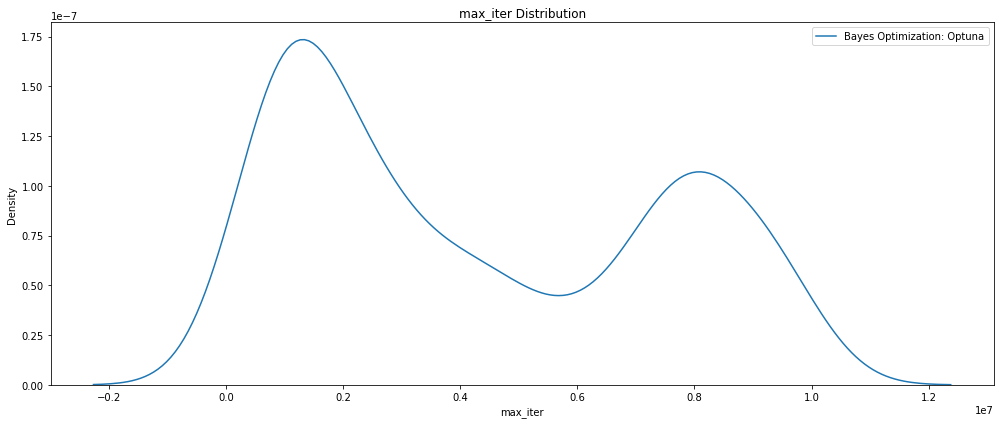

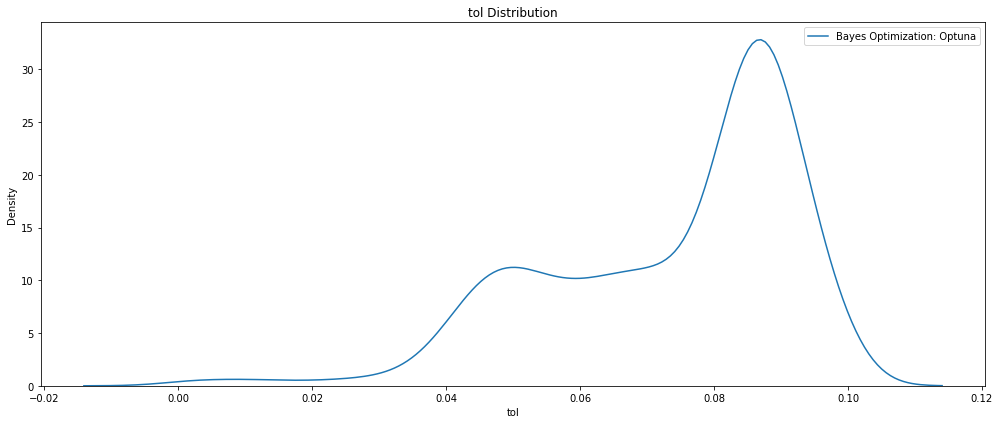

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','fit_intercept', 'normalize', 'selection',
                   'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

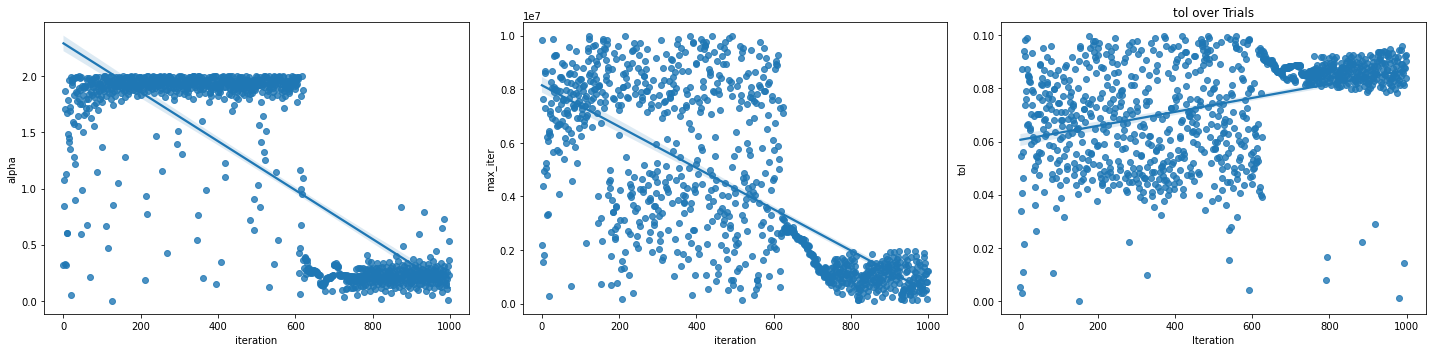

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['alpha', 'max_iter', 'tol']): 
                        # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel= '{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Lasso_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Lasso_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'alpha': 0.2182309981031917,
 'max_iter': 370243,
 'selection': 'cyclic',
 'tol': 0.09356059105037583}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = Lasso(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Lasso_Optuna_SMOTE_trials1000_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Lasso_Optuna_SMOTE_trials1000_GPU_Recall.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Lasso HPO SMOTE 1000 Recall GPU trials')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Lasso HPO SMOTE 1000 Recall GPU trials


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    377848
           1       0.88      0.87      0.88     54625

    accuracy                           0.97    432473
   macro avg       0.93      0.93      0.93    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[371177   6671]
 [  6897  47728]]


Accuracy score : 0.969
Precision score : 0.877
Recall score : 0.874
F1 score : 0.876


In [ ]:
# Evaluate on the testing data 
print('The best model from Lasso HPO SMOTE 1000 Recall GPU Precision trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                                      cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Lasso HPO SMOTE 1000 Recall GPU Precision trials optimization scores 0.92804 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   929
recall                                 0.873739
datetime_start       2022-06-13 23:39:47.273320
datetime_complete    2022-06-13 23:39:48.132259
duration                 0 days 00:00:00.858939
alpha                                  0.218231
max_iter                                 370243
selection                                cyclic
tol                                    0.093561
state                                  COMPLETE
Name: 929, dtype: object


### Precision

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_lasso_optuna_SMOTE_1000_Precision_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0, 
                   max_iter=1e6, tol=1e-3, selection='cyclic', 
                   fit_intercept=True, normalize=False, verbose=0,
                   handle=None): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Precision of the fitted model
    """
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = Lasso(alpha=alpha, max_iter=max_iter, tol=tol, 
                  selection=selection, fit_intercept=fit_intercept, 
                  normalize=normalize, verbose=verbose, handle=handle) 
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = precision_score(y_test.to_numpy(), cupy.asnumpy(y_pred)) 

    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial Precision score:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 1.0982644870000513
- Trial Precision score: 0.9999780735413424
######################################################
Score with default parameters :  0.9999780735413424


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Lasso_Optuna_SMOTE_1000_GPU_Precision.pkl')
    
    # Search parameters
    alpha = trial.suggest_float('alpha', 1e-3, 2.0) 
    max_iter = trial.suggest_int('max_iter', 1e5, 1e7) 
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, max_iter=max_iter, 
                           tol=tol, selection=selection,
                           fit_intercept=True, 
                           normalize=False, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Lasso_Optuna_SMOTE_1000_GPU_Precision.pkl'): 
        study = joblib.load('Lasso_Optuna_SMOTE_1000_GPU_Precision.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision score', study.best_value)

Start Time           2022-06-13 23:43:10.806091
- Trial time: 0.817463585999576
- Trial Precision score: 0.9999780812309581
######################################################
- Trial time: 0.49411897199934174
- Trial Precision score: 0.999544201593124
######################################################
- Trial time: 0.3390393669997138
- Trial Precision score: 0.9998064183085262
######################################################
- Trial time: 0.78309288499986
- Trial Precision score: 0.9999780648840729
######################################################
- Trial time: 0.9791939560000174
- Trial Precision score: 0.99997808171138
######################################################
- Trial time: 0.6586080010001751
- Trial Precision score: 0.9999780730605622
######################################################
- Trial time: 0.5697330679995503
- Trial Precision score: 0.9912050010778185
######################################################
- Trial time: 0.3778179929995531


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'precision'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_fit_intercept':'fit_intercept'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_normalize':'normalize'}, inplace=True)
trials_df.rename(columns={'params_selection':'selection'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)

# Write processed data to csv    
trials_df = trials_df.sort_values('precision', ascending=False)
trials_df.to_csv('Lasso_Optuna_SMOTE_1000_GPU_Precision.csv', index=False)
print(trials_df) 

     iteration  precision             datetime_start  \
980        980   0.999978 2022-06-13 23:56:31.986830   
993        993   0.999978 2022-06-13 23:56:44.531862   
996        996   0.999978 2022-06-13 23:56:47.702286   
995        995   0.999978 2022-06-13 23:56:46.414358   
997        997   0.999978 2022-06-13 23:56:48.684320   
..         ...        ...                        ...   
482        482   0.983732 2022-06-13 23:49:00.095559   
633        633   0.978770 2022-06-13 23:51:07.969359   
140        140   0.955840 2022-06-13 23:44:44.549942   
733        733   0.886149 2022-06-13 23:52:36.104251   
36          36   0.829167 2022-06-13 23:43:34.913151   

             datetime_complete               duration     alpha  max_iter  \
980 2022-06-13 23:56:32.961363 0 days 00:00:00.974533  1.134804   2122579   
993 2022-06-13 23:56:45.508049 0 days 00:00:00.976187  1.127781   2124077   
996 2022-06-13 23:56:48.683616 0 days 00:00:00.981330  1.123869   2202675   
995 2022-06-13 23:5

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Lasso_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Lasso_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Lasso_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'max_iter', 'tol'])
py.plot(fig, filename='contour_Lasso_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

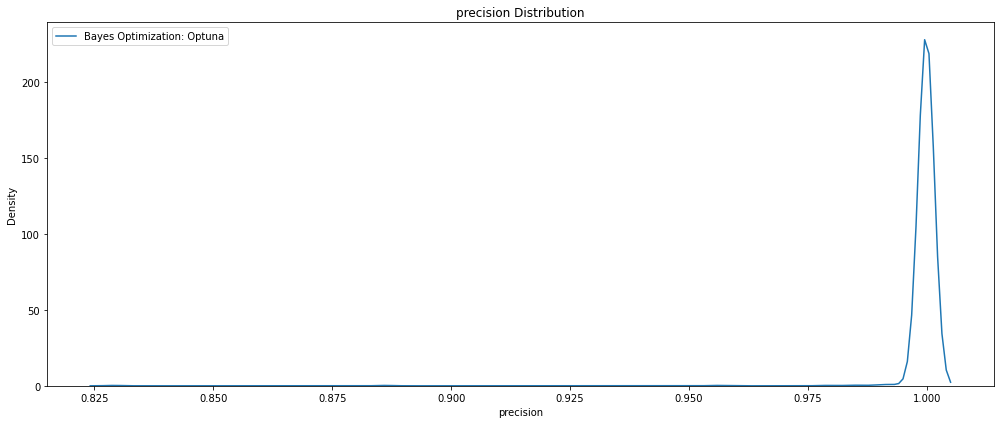

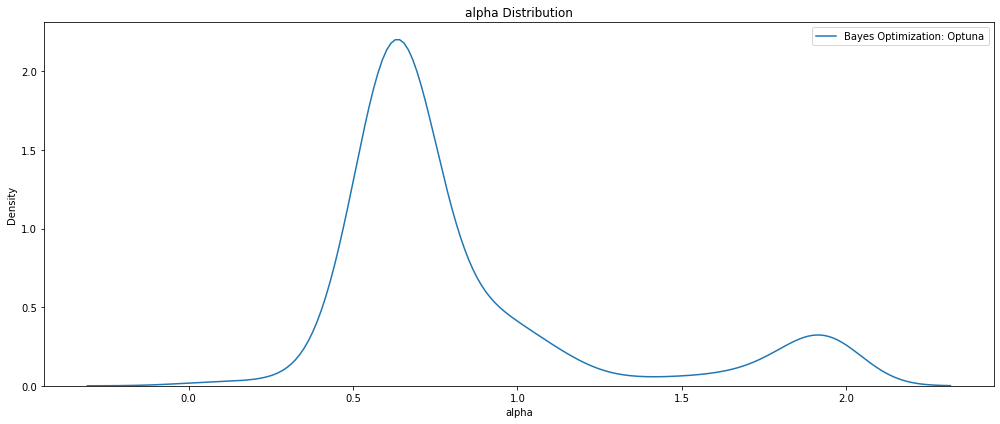

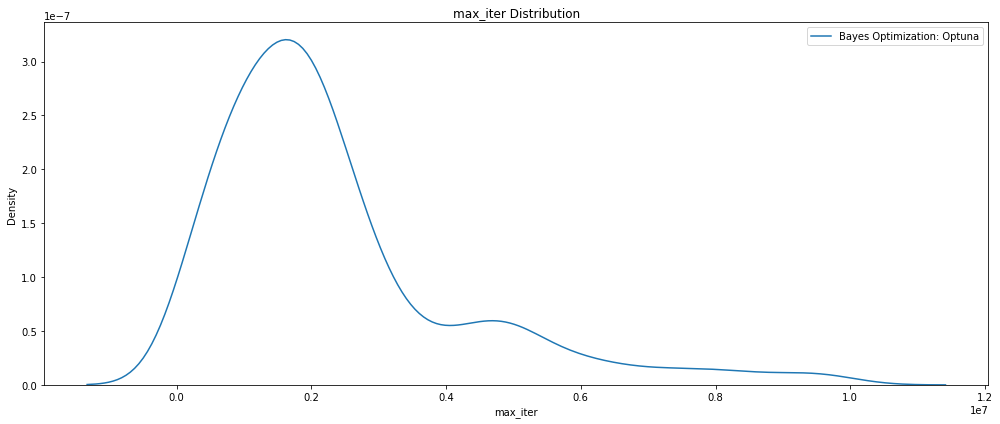

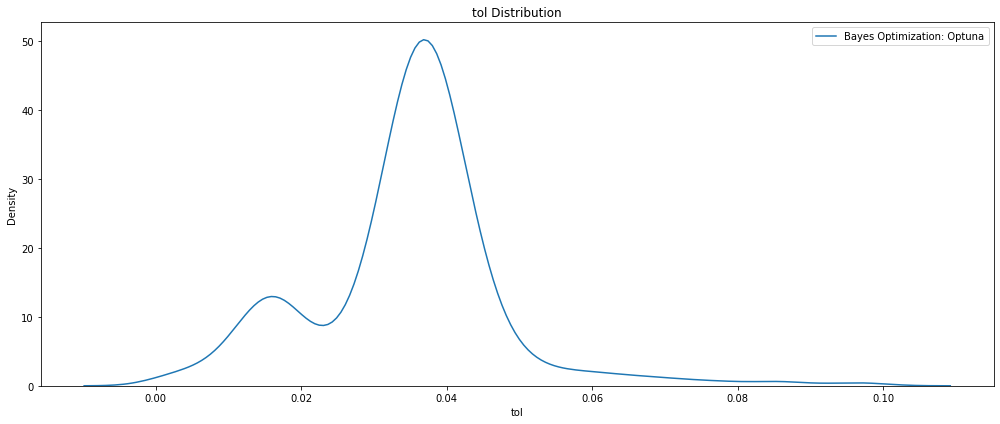

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','fit_intercept', 'normalize', 'selection',
                   'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

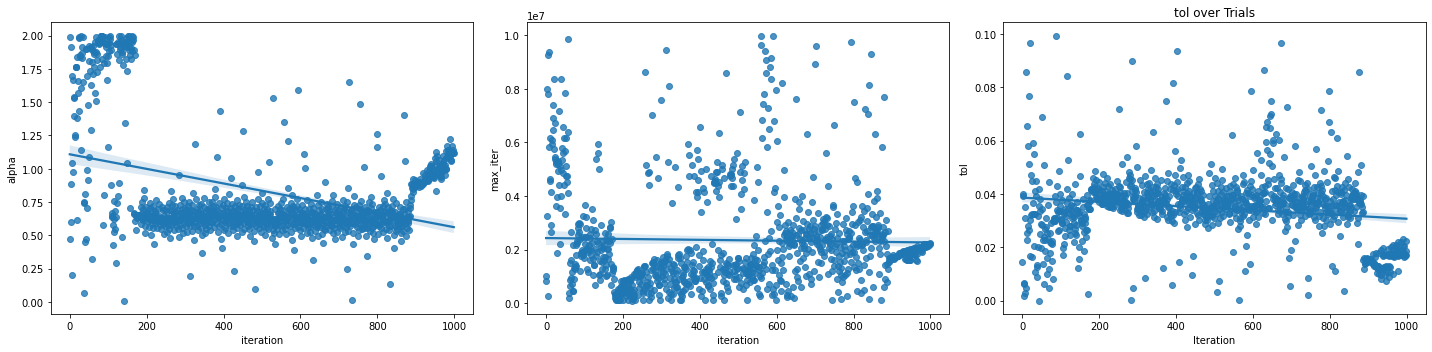

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['alpha', 'max_iter', 'tol']): 
                        # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Lasso_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Lasso_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'alpha': 1.134804393816228,
 'max_iter': 2122579,
 'selection': 'random',
 'tol': 0.01732361419940628}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = Lasso(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Lasso_Optuna_SMOTE_trials1000_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Lasso_Optuna_SMOTE_trials1000_GPU_Precision.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Lasso HPO SMOTE 1000 Precision GPU trials')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Lasso HPO SMOTE 1000 Precision GPU trials


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    377848
           1       1.00      0.85      0.92     54625

    accuracy                           0.98    432473
   macro avg       0.99      0.92      0.95    432473
weighted avg       0.98      0.98      0.98    432473



Confusion matrix:
[[377847      1]
 [  8314  46311]]


Accuracy score : 0.981
Precision score : 1.000
Recall score : 0.848
F1 score : 0.918


In [ ]:
# Evaluate on the testing data 
print('The best model from Lasso HPO SMOTE 1000 Precision GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                               cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Lasso HPO SMOTE 1000 Precision GPU trials optimization scores 0.92390 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   980
precision                              0.999978
datetime_start       2022-06-13 23:56:31.986830
datetime_complete    2022-06-13 23:56:32.961363
duration                 0 days 00:00:00.974533
alpha                                  1.134804
max_iter                                2122579
selection                                random
tol                                    0.017324
state                                  COMPLETE
Name: 980, dtype: object


## Elastic Net

### F1 Weighted

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_elnet_optuna_SMOTE_1000_weightedF1_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0,
                   l1_ratio=0.5, max_iter=1e6, 
                   tol=1e-3, selection='cyclic', 
                   fit_intercept=True, normalize=False, verbose=0,
                   handle=None): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: F1 weighted of the fitted model
    """
    
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, 
                       max_iter=max_iter, tol=tol, 
                       selection=selection, fit_intercept=fit_intercept, 
                       normalize=normalize, verbose=verbose, handle=handle)  
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = f1_score(y_test.to_numpy(), cupy.asnumpy(y_pred), average='weighted') 

    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted F1:', score)
    print('######################################################')
    
    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 0.9294645159989159
- Trial weighted F1: 0.9785048322774689
######################################################
Score with default parameters :  0.9785048322774689


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Elnet_Optuna_SMOTE_1000_GPU_F1weighted.pkl')
     
    # Search parameters
    alpha = trial.suggest_float('alpha', 1e-3, 2.0) 
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    max_iter = trial.suggest_int('max_iter', 1e5, 1e7) 
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    normalize = trial.suggest_categorical('normalize', [True, False])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, l1_ratio=l1_ratio,
                           max_iter=max_iter, tol=tol, 
                           selection=selection,
                           fit_intercept=fit_intercept, 
                           normalize=normalize, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Elnet_Optuna_SMOTE_1000_GPU_F1weighted.pkl'): 
        study = joblib.load('Elnet_Optuna_SMOTE_1000_GPU_F1weighted.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 weighted score:', study.best_value)

Start Time           2022-06-13 23:58:36.702254
- Trial time: 0.2691337870001007
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.25949724900056026
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.3225066250015516
- Trial weighted F1: 0.9096294141223438
######################################################
- Trial time: 0.271549914001298
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.35879036799997266
- Trial weighted F1: 0.935343363128046
######################################################
- Trial time: 0.26141695200021786
- Trial weighted F1: 0.8147946302801139
######################################################
- Trial time: 0.519867842000167
- Trial weighted F1: 0.9783427605678774
######################################################
- Trial time: 0.2735241610007506
- Trial weighted F1: 0.

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'f1_weighted'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_fit_intercept':'fit_intercept'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_normalize':'normalize'}, inplace=True)
trials_df.rename(columns={'params_selection':'selection'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('f1_weighted', ascending=True)
trials_df.to_csv('Elnet_Optuna_SMOTE_1000_GPU_weightedF1.csv', index=False)
print(trials_df) 

     iteration  f1_weighted             datetime_start  \
0            0     0.814795 2022-06-13 23:58:36.705082   
743        743     0.814795 2022-06-14 00:07:42.521243   
761        761     0.814795 2022-06-14 00:07:58.881396   
198        198     0.814795 2022-06-14 00:00:41.512280   
780        780     0.814795 2022-06-14 00:08:16.570111   
..         ...          ...                        ...   
553        553     0.980779 2022-06-14 00:04:59.088115   
967        967     0.980779 2022-06-14 00:11:20.542285   
897        897     0.980779 2022-06-14 00:10:08.712145   
664        664     0.980779 2022-06-14 00:06:32.120781   
999        999          NaN 2022-06-14 00:11:54.592810   

             datetime_complete               duration     alpha fit_intercept  \
0   2022-06-13 23:58:37.158019 0 days 00:00:00.452937  0.592741         False   
743 2022-06-14 00:07:43.307944 0 days 00:00:00.786701  1.931848          True   
761 2022-06-14 00:07:59.687361 0 days 00:00:00.805965  1.850

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Elnet_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Elnet_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Elnet_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'l1_ratio', 
                                                       'max_iter', 'tol'])
py.plot(fig, filename='contour_Elnet_SMOTE_Optuna_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','fit_intercept', 'normalize',
                   'selection', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['alpha', 'l1_ratio', 'max_iter', 'tol']): 
                        # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Elnet_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Elnet_Optuna_SMOTE_1000_GPU_weightedF1.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = ElasticNet(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Elnet_Optuna_SMOTE_trials1000_GPU_F1weighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Elnet_Optuna_SMOTE_trials1000_GPU_F1weighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Elastic Net HPO SMOTE 1000 GPU F1 weighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Elastic Net HPO SMOTE 1000 GPU F1 weighted


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    377848
           1       1.00      0.85      0.92     54625

    accuracy                           0.98    432473
   macro avg       0.99      0.93      0.96    432473
weighted avg       0.98      0.98      0.98    432473



Confusion matrix:
[[377843      5]
 [  8031  46594]]


Accuracy score : 0.981
Precision score : 1.000
Recall score : 0.853
F1 score : 0.921


In [ ]:
# Evaluate on the testing data 
print('The best model from Elastic Net HPO SMOTE 1000 F1 weighted GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                                       cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Elastic Net HPO SMOTE 1000 F1 weighted GPU trials optimization scores 0.92648 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                     0
f1_weighted                            0.814795
datetime_start       2022-06-13 23:58:36.705082
datetime_complete    2022-06-13 23:58:37.158019
duration                 0 days 00:00:00.452937
alpha                                  0.592741
fit_intercept                             False
l1_ratio                               0.656826
max_iter                              2176114.0
normalize                                  True
selection                                cyclic
tol                                    0.037134
state                                  COMPLETE
Name: 0, dtype: object


### ROC Weighted

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_elnet_optuna_SMOTE_1000_weightedROC_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0,
                   l1_ratio=0.5, max_iter=1e6, 
                   tol=1e-3, selection='cyclic', 
                   fit_intercept=True, normalize=False, verbose=0,
                   handle=None): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: ROC weighted of the fitted model
    """

    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, 
                       max_iter=max_iter, tol=tol, 
                       selection=selection, fit_intercept=fit_intercept, 
                       normalize=normalize, verbose=verbose, handle=handle)  
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = roc_auc_score(y_test.to_numpy(), cupy.asnumpy(y_pred), 
                          average='weighted') 

    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted ROC:', score)
    print('######################################################')
    
    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 0.8724870930000179
- Trial weighted ROC: 0.918156103550072
######################################################
Score with default parameters :  0.918156103550072


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Elnet_Optuna_SMOTE_1000_GPU_ROCweighted.pkl')
     
    # Search parameters
    alpha = trial.suggest_float('alpha', 1e-3, 2.0) 
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    max_iter = trial.suggest_int('max_iter', 1e5, 1e7) 
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    normalize = trial.suggest_categorical('normalize', [True, False])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, l1_ratio=l1_ratio,
                           max_iter=max_iter, tol=tol, 
                           selection=selection,
                           fit_intercept=fit_intercept, 
                           normalize=normalize, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Elnet_Optuna_SMOTE_1000_GPU_ROCweighted.pkl'): 
        study = joblib.load('Elnet_Optuna_SMOTE_1000_GPU_ROCweighted.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROC weighted score:', study.best_value)

Start Time           2022-06-14 01:20:20.588298
- Trial time: 0.326783902999523
- Trial weighted ROC: 0.9265113793412357
######################################################
- Trial time: 0.2996940530010761
- Trial weighted ROC: 0.5
######################################################
- Trial time: 0.38881077199948777
- Trial weighted ROC: 0.9237892103114411
######################################################
- Trial time: 0.3246278679998795
- Trial weighted ROC: 0.9264904261382065
######################################################
- Trial time: 0.3404680300009204
- Trial weighted ROC: 0.9242304411925089
######################################################
- Trial time: 0.3081980829992972
- Trial weighted ROC: 0.9193794888620596
######################################################
- Trial time: 0.33971168199968815
- Trial weighted ROC: 0.9264945056544962
######################################################
- Trial time: 0.2993436019987712
- Trial weighted ROC: 0.926386

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'roc_weighted'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_fit_intercept':'fit_intercept'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_normalize':'normalize'}, inplace=True)
trials_df.rename(columns={'params_selection':'selection'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('roc_weighted', ascending=True)
trials_df.to_csv('Elnet_Optuna_SMOTE_1000_GPU_ROCweighted.csv', index=False)
print(trials_df) 

      iteration  roc_weighted             datetime_start  \
1171       1171      0.500000 2022-06-14 01:23:24.135204   
1057       1057      0.500000 2022-06-14 01:21:22.867794   
1039       1039      0.500000 2022-06-14 01:21:04.267329   
1609       1609      0.500000 2022-06-14 01:32:15.700515   
1022       1022      0.500000 2022-06-14 01:20:46.188398   
...         ...           ...                        ...   
1207       1207      0.930495 2022-06-14 01:24:03.570562   
958         958      0.930498 2022-06-14 00:28:28.996098   
1167       1167      0.930499 2022-06-14 01:23:19.635950   
1510       1510      0.930503 2022-06-14 01:30:07.115148   
999         999           NaN 2022-06-14 00:29:11.316543   

              datetime_complete               duration     alpha  \
1171 2022-06-14 01:23:25.063517 0 days 00:00:00.928313  0.603780   
1057 2022-06-14 01:21:24.079355 0 days 00:00:01.211561  0.630758   
1039 2022-06-14 01:21:05.169536 0 days 00:00:00.902207  0.524023   
1609 20

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Elnet_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Elnet_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Elnet_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'l1_ratio', 
                                                       'max_iter', 'tol'])
py.plot(fig, filename='contour_Elnet_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','fit_intercept', 'normalize',
                   'selection', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['alpha', 'l1_ratio', 'max_iter', 'tol']): 
                        # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Elnet_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Elnet_Optuna_SMOTE_1000_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'alpha': 0.7677274920028477,
 'fit_intercept': True,
 'l1_ratio': 0.25671557850175375,
 'max_iter': 9153573,
 'normalize': False,
 'selection': 'random',
 'tol': 0.08710895306976506}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = ElasticNet(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Elnet_Optuna_SMOTE_trials1000_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Elnet_Optuna_SMOTE_trials1000_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Elastic Net HPO SMOTE 1000 GPU ROC weighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Elastic Net HPO SMOTE 1000 GPU ROC weighted


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    377848
           1       0.98      0.86      0.92     54625

    accuracy                           0.98    432473
   macro avg       0.98      0.93      0.95    432473
weighted avg       0.98      0.98      0.98    432473



Confusion matrix:
[[376862    986]
 [  7450  47175]]


Accuracy score : 0.980
Precision score : 0.980
Recall score : 0.864
F1 score : 0.918


In [ ]:
# Evaluate on the testing data 
print('The best model from Elastic Net HPO SMOTE 1000 ROC weighted GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                                        cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Elastic Net HPO SMOTE 1000 ROC weighted GPU trials optimization scores 0.93050 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                  1171
roc_weighted                                0.5
datetime_start       2022-06-14 01:23:24.135204
datetime_complete    2022-06-14 01:23:25.063517
duration                 0 days 00:00:00.928313
alpha                                   0.60378
fit_intercept                              True
l1_ratio                               0.286064
max_iter                              6660341.0
normalize                                  True
selection                                random
tol                                    0.089028
state                                  COMPLETE
Name: 1171, dtype: object


### Recall

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_elnet_optuna_SMOTE_1000_Recall_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0,
                   l1_ratio=0.5, max_iter=1e6, 
                   tol=1e-3, selection='cyclic', 
                   fit_intercept=True, normalize=False, verbose=0,
                   handle=None): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Recall of the fitted model
    """
    
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, 
                       max_iter=max_iter, tol=tol, 
                       selection=selection, fit_intercept=fit_intercept, 
                       normalize=normalize, verbose=verbose, handle=handle)  
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = recall_score(y_test.to_numpy(), cupy.asnumpy(y_pred)) 

    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial Recall score:', score)
    print('######################################################')
    
    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 0.9203844529984053
- Trial Recall score: 0.8363386727688787
######################################################
Score with default parameters :  0.8363386727688787


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Elnet_Optuna_SMOTE_1000_GPU_Recall.pkl')
     
    # Search parameters
    alpha = trial.suggest_float('alpha', 1e-3, 2.0) 
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    max_iter = trial.suggest_int('max_iter', 1e5, 1e7) 
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    normalize = trial.suggest_categorical('normalize', [True, False])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, l1_ratio=l1_ratio,
                           max_iter=max_iter, tol=tol, 
                           selection=selection,
                           fit_intercept=fit_intercept, 
                           normalize=normalize, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Elnet_Optuna_SMOTE_1000_GPU_Recall.pkl'): 
        study = joblib.load('Elnet_Optuna_SMOTE_1000_GPU_Recall.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall score:', study.best_value)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'recall'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_fit_intercept':'fit_intercept'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_normalize':'normalize'}, inplace=True)
trials_df.rename(columns={'params_selection':'selection'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('recall', ascending=True)
trials_df.to_csv('Elnet_Optuna_SMOTE_1000_GPU_Recall.csv', index=False)
print(trials_df) 

     iteration    recall             datetime_start  \
0            0  0.000000 2022-06-14 00:35:40.541909   
576        576  0.000000 2022-06-14 00:42:22.664641   
595        595  0.000000 2022-06-14 00:42:38.697494   
614        614  0.000000 2022-06-14 00:42:55.045026   
634        634  0.000000 2022-06-14 00:43:12.361454   
..         ...       ...                        ...   
615        615  0.873574 2022-06-14 00:42:55.793835   
382        382  0.873574 2022-06-14 00:39:49.518505   
704        704  0.873593 2022-06-14 00:44:14.842886   
410        410  0.873593 2022-06-14 00:40:10.372771   
999        999       NaN 2022-06-14 00:49:08.978814   

             datetime_complete               duration     alpha fit_intercept  \
0   2022-06-14 00:35:41.031016 0 days 00:00:00.489107  0.674484         False   
576 2022-06-14 00:42:23.415970 0 days 00:00:00.751329  0.733392          True   
595 2022-06-14 00:42:39.441873 0 days 00:00:00.744379  1.437444          True   
614 2022-06-14 

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Elnet_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Elnet_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Elnet_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'l1_ratio', 
                                                       'max_iter', 'tol'])
py.plot(fig, filename='contour_Elnet_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

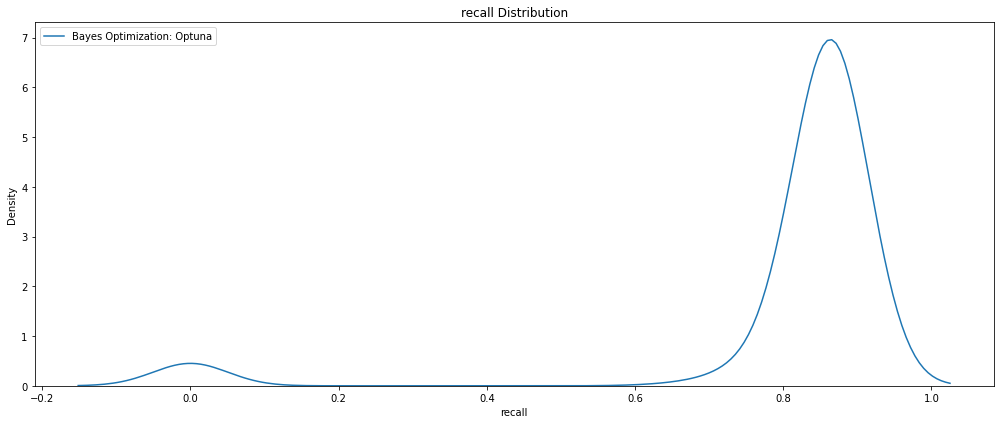

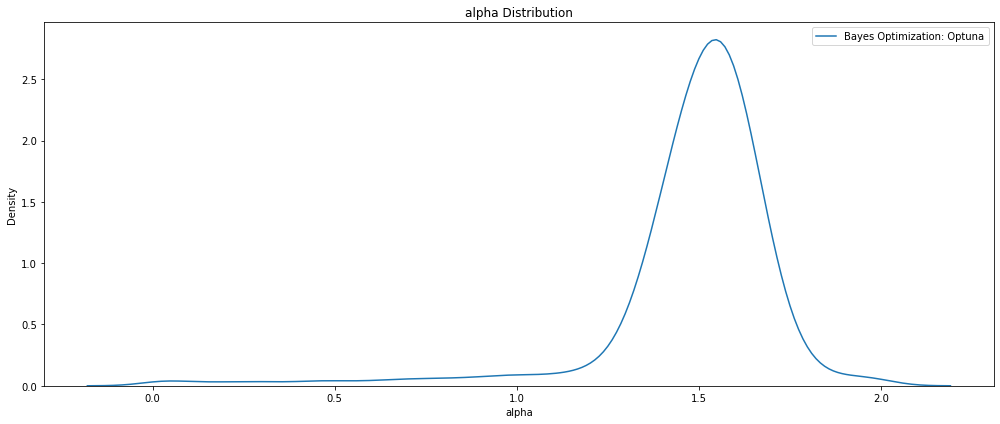

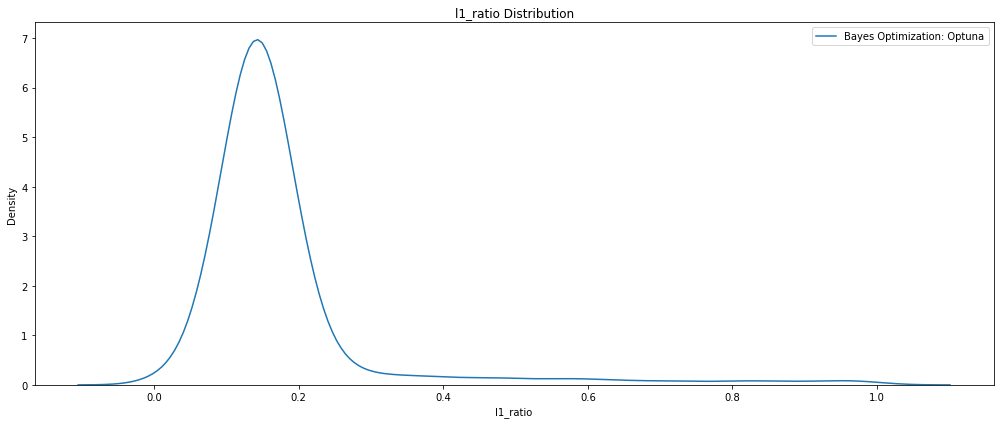

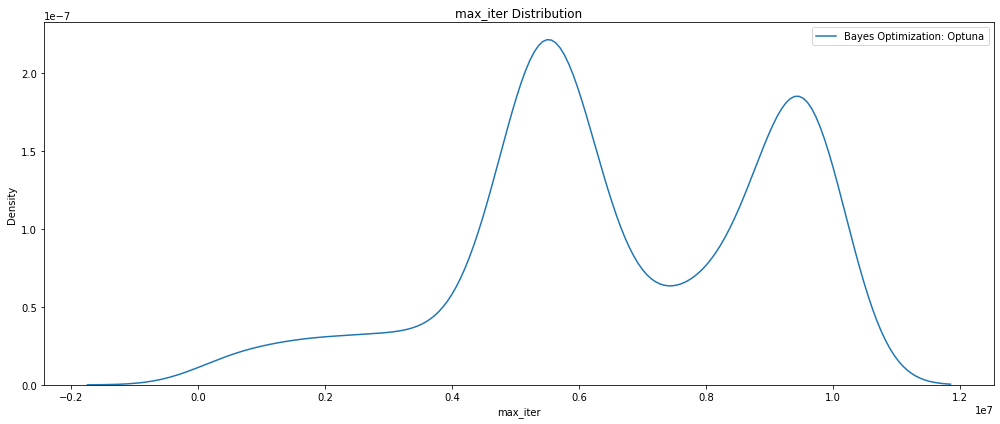

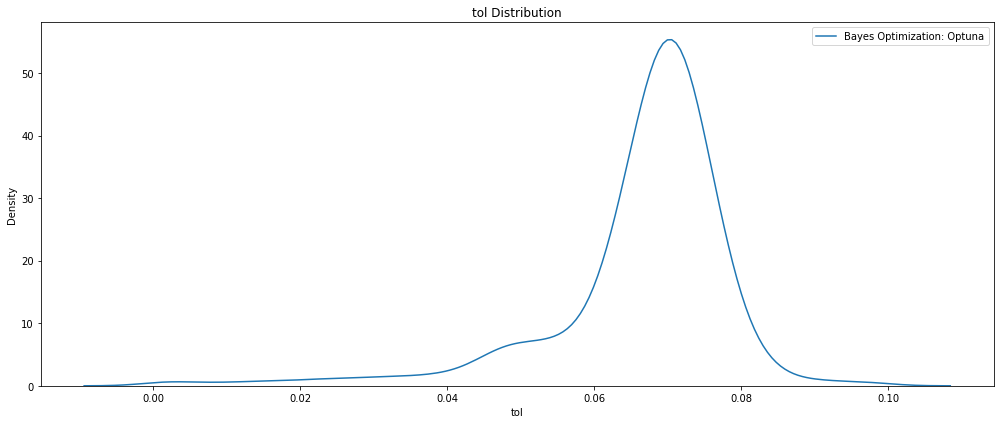

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','fit_intercept', 'normalize',
                   'selection', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['alpha', 'l1_ratio', 'max_iter', 'tol']): 
                        # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel='{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Elnet_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Elnet_Optuna_SMOTE_1000_GPU_Recall.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

{'alpha': 1.4940414756418035,
 'fit_intercept': True,
 'l1_ratio': 0.14342241319292748,
 'max_iter': 543150,
 'normalize': False,
 'selection': 'cyclic',
 'tol': 0.0642788774158715}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = ElasticNet(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Elnet_Optuna_SMOTE_trials1000_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Elnet_Optuna_SMOTE_trials1000_GPU_Recall.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Elastic Net HPO SMOTE 1000 GPU Recall')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Elastic Net HPO SMOTE 1000 GPU Recall


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    377848
           1       0.88      0.87      0.87     54625

    accuracy                           0.97    432473
   macro avg       0.93      0.93      0.93    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[371114   6734]
 [  6905  47720]]


Accuracy score : 0.968
Precision score : 0.876
Recall score : 0.874
F1 score : 0.875


In [ ]:
# Evaluate on the testing data 
print('The best model from Elastic Net HPO SMOTE 1000 Recall GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                                  cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Elastic Net HPO SMOTE 1000 Recall GPU trials optimization scores 0.92789 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                     0
recall                                      0.0
datetime_start       2022-06-14 00:35:40.541909
datetime_complete    2022-06-14 00:35:41.031016
duration                 0 days 00:00:00.489107
alpha                                  0.674484
fit_intercept                             False
l1_ratio                               0.950712
max_iter                              4812529.0
normalize                                  True
selection                                cyclic
tol                                    0.039008
state                                  COMPLETE
Name: 0, dtype: object


### Precision

#### 1000 Trials

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL

# Define a name for the trials
study_name = 'dask_elnet_optuna_SMOTE_1000_Precision_tpe'

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, alpha=1.0,
                   l1_ratio=0.5, max_iter=1e6, 
                   tol=1e-3, selection='cyclic', 
                   fit_intercept=True, normalize=False, verbose=0,
                   handle=None): 
    """
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Precision of the fitted model
    """
    
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
    X_test = X_test.astype('float32')

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, 
                       max_iter=max_iter, tol=tol, 
                       selection=selection, fit_intercept=fit_intercept, 
                       normalize=normalize, verbose=verbose, handle=handle)  
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    p_pred = model.predict(X_test)
    p_pred = p_pred.round(2)
    y_pred = cupy.where(p_pred > 0.5, 1, 0)

    score = precision_score(y_test.to_numpy(), cupy.asnumpy(y_pred)) 

    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial Precision score:', score)
    print('######################################################')
    
    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 0.9162488309993932
- Trial Precision score: 0.9997811576758945
######################################################
Score with default parameters :  0.9997811576758945


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):
    
    joblib.dump(study, 'Elnet_Optuna_SMOTE_1000_GPU_Precision.pkl')
     
    # Search parameters
    alpha = trial.suggest_float('alpha', 1e-3, 2.0) 
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    max_iter = trial.suggest_int('max_iter', 1e5, 1e7) 
    tol = trial.suggest_float('tol', 1e-5, 1e-1)  
    selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    normalize = trial.suggest_categorical('normalize', [True, False])
    
    score = train_and_eval(X_param, y_param, 
                           alpha=alpha, l1_ratio=l1_ratio,
                           max_iter=max_iter, tol=tol, 
                           selection=selection,
                           fit_intercept=fit_intercept, 
                           normalize=normalize, 
                           handle=None, 
                           verbose=0)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('Elnet_Optuna_SMOTE_1000_GPU_Precision.pkl'): 
        study = joblib.load('Elnet_Optuna_SMOTE_1000_GPU_Precision.pkl')
    else: 
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                    study_name=study_name,
                                    direction='maximize')

    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=1000)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision score:', study.best_value)

Start Time           2022-06-14 02:21:01.282393
- Trial time: 0.3018880999989051
- Trial Precision score: 0.55543075195027
######################################################
- Trial time: 0.26358968899876345
- Trial Precision score: 0.0
######################################################
- Trial time: 0.26868888700118987
- Trial Precision score: 0.0
######################################################
- Trial time: 0.35802607600271585
- Trial Precision score: 0.9883969594952254
######################################################
- Trial time: 0.36137062600028
- Trial Precision score: 0.6456788663885558
######################################################
- Trial time: 0.25681523000093875
- Trial Precision score: 0.0
######################################################
- Trial time: 0.2627325529974769
- Trial Precision score: 0.0
######################################################
- Trial time: 0.25658604899945203
- Trial Precision score: 0.0
#########################

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'precision'},inplace=True)
trials_df.rename(columns={'params_alpha':'alpha'}, inplace=True)
trials_df.rename(columns={'params_fit_intercept':'fit_intercept'}, inplace=True)
trials_df.rename(columns={'params_l1_ratio':'l1_ratio'}, inplace=True)
trials_df.rename(columns={'params_max_iter':'max_iter'}, inplace=True)
trials_df.rename(columns={'params_normalize':'normalize'}, inplace=True)
trials_df.rename(columns={'params_selection':'selection'}, inplace=True)
trials_df.rename(columns={'params_tol':'tol'}, inplace=True)

# Write processed data to csv
trials_df = trials_df.sort_values('precision', ascending=True)
trials_df.to_csv('Elnet_Optuna_SMOTE_1000_GPU_Precision.csv', index=False)
print(trials_df) 

     iteration  precision             datetime_start  \
828        828   0.000000 2022-06-14 02:32:26.514923   
675        675   0.000000 2022-06-14 02:29:50.627054   
313        313   0.000000 2022-06-14 02:24:30.415188   
848        848   0.000000 2022-06-14 02:32:47.941958   
34          34   0.000000 2022-06-14 02:21:22.383341   
..         ...        ...                        ...   
604        604   0.999978 2022-06-14 02:28:43.202296   
598        598   0.999978 2022-06-14 02:28:37.632917   
741        741   0.999978 2022-06-14 02:30:55.868751   
638        638   0.999978 2022-06-14 02:29:14.936573   
864        864   0.999978 2022-06-14 02:33:05.299953   

             datetime_complete               duration     alpha  \
828 2022-06-14 02:32:27.352029 0 days 00:00:00.837106  1.483647   
675 2022-06-14 02:29:51.399559 0 days 00:00:00.772505  1.537790   
313 2022-06-14 02:24:31.023451 0 days 00:00:00.608263  1.605796   
848 2022-06-14 02:32:48.809191 0 days 00:00:00.867233  1.42

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Elnet_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Elnet_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Elnet_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['alpha', 'l1_ratio', 
                                                       'max_iter', 'tol'])
py.plot(fig, filename='contour_Elnet_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','fit_intercept', 'normalize',
                   'selection', 'state']:
        plt.figure(figsize=(14,6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label='Bayes Optimization: Optuna')
            plt.legend(loc=0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize=(20,5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['alpha', 'l1_ratio', 'max_iter', 'tol']): 
                        # Scatterplot
                         sns.regplot('iteration', hpo, data=trials_df, ax=axs[i]) 
                         axs[i].set(xlabel='Iteration', ylabel= '{}'.format(hpo),  
                                    title='{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Elnet_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Elnet_Optuna_SMOTE_1000_GPU_Precision.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params = study.best_params   
params

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/Linear/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_train = X_train.astype('float32')

X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = ElasticNet(**params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Elnet_Optuna_SMOTE_trials1000_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Elnet_Optuna_SMOTE_trials1000_GPU_Precision.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for Elastic Net HPO SMOTE 1000 GPU Precision')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_train_pred = y_train_pred.round(2)
y_train_pred = cupy.where(y_train_pred > 0.5, 1, 0)

y_test_pred = best_model.predict(X_test)
y_test_pred = y_test_pred.round(2)
y_test_pred = cupy.where(y_test_pred > 0.5, 1, 0)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), cupy.asnumpy(y_test_pred))
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), 
                                             cupy.asnumpy(y_test_pred)))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), 
                                               cupy.asnumpy(y_test_pred)))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), 
                                         cupy.asnumpy(y_test_pred)))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), cupy.asnumpy(y_test_pred)))


Model Metrics for Elastic Net HPO SMOTE 1000 GPU Precision


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    377848
           1       1.00      0.85      0.92     54625

    accuracy                           0.98    432473
   macro avg       0.99      0.92      0.95    432473
weighted avg       0.98      0.98      0.98    432473



Confusion matrix:
[[377847      1]
 [  8304  46321]]


Accuracy score : 0.981
Precision score : 1.000
Recall score : 0.848
F1 score : 0.918


In [ ]:
# Evaluate on the testing data 
print('The best model from Elastic Net HPO SMOTE 1000 Precision GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), 
                                                                                                                                                     cupy.asnumpy(y_test_pred))))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Elastic Net HPO SMOTE 1000 Precision GPU trials optimization scores 0.92399 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   828
precision                                   0.0
datetime_start       2022-06-14 02:32:26.514923
datetime_complete    2022-06-14 02:32:27.352029
duration                 0 days 00:00:00.837106
alpha                                  1.483647
fit_intercept                              True
l1_ratio                                0.73664
max_iter                                8517858
normalize                                  True
selection                                random
tol                                    0.018749
state                                  COMPLETE
Name: 828, dtype: object
